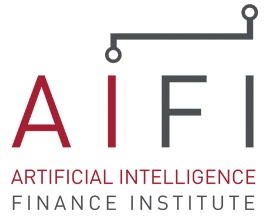


# Bootcamp - Python and Coding - Deep Learning

# Long Short Term Memory (LSTMs)

|Input gate  | Forget gate   | Gate  | Output gate   | 
|---|---|---|---|
Write to cell or not? | Erase a cell or not?  | How much to write to cell? | How much to reveal cell?


			
			


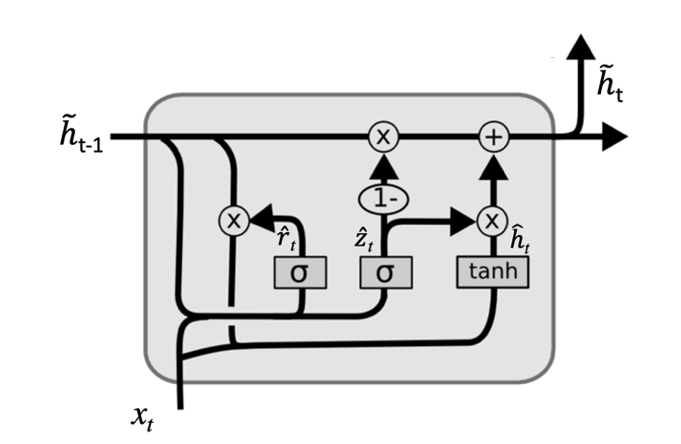

<font size=5>
$$
\begin{aligned}
f_{t} &=\sigma\left(W_{f} \cdot\left[h_{t-1}, x_{t}\right]+b_{f}\right) \\
i_{t} &=\sigma\left(W_{i} \cdot\left[h_{t-1}, x_{t}\right]+b_{i}\right) \\
\widetilde{C}_{t} &=\tanh \left(W_{C} \cdot\left[h_{t-1}, x_{t}\right]+b_{C}\right) \\
C_{t} &=f_{t} * C_{t-1}+i_{t} * \widetilde{C}_{t} \\
o_{t} &=\sigma\left(W_{o}\left[h_{t-1}, x_{t}\right]+b_{o}\right) \\
h_{t} &=o_{t} * \tanh \left(C_{t}\right)
\end{aligned}
$$
<font>

# About this notebook

The goal of this notebook is to demonstrate how to use `Grid Search CV` and the `scikit learn` wrapper `KerasRegressor` to optimize the hyperparameters of a given model. Furthermore, this notebook contains examples on how to validate cross-validation and how to check the model for under- and overfitting. And as a final part, an example is given of how Tensorboard can be used as a callback when training a model and then checking the performance of the model. 

We will use techniques to optimize the training of the network based on the following paper:
- [Practical recommendations for gradient-based training of deep architectures](https://arxiv.org/abs/1206.5533)
- [On the difficulty of training Recurrent Neural Networks](https://arxiv.org/abs/1211.5063)
- [Understanding the exploding gradient problem](https://arxiv.org/abs/1211.5063)
- [Improving neural
networks by preventing co-adaptation of feature](http://arxiv.org/abs/1207.0580)
- [Overfitting in Neural Nets: Backpropagation,
Conjugate Gradient, and Early Stopping](https://proceedings.neurips.cc/paper/2000/file/059fdcd96baeb75112f09fa1dcc740cc-Paper.pdf)
- [Learning curve models and applications: Literature
review and research directions](https://www.sciencedirect.com/science/article/abs/pii/S016981411100062X)

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import sys
import os
import time
from datetime import datetime
from importlib import reload
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from scipy.stats import t

# tensorflow and keras imports
import tensorflow.keras.initializers
from keras.models import Sequential
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN, Dropout
from keras.regularizers import l1
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# to make this notebook's output stable across runs
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# surpress scientific notation
pd.options.display.float_format = '{:.8f}'.format

# custom library with functions
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path

from customlib import model_analysis as ma
from customlib import preprocessing as pre
from customlib import plotting
from customlib import model_analysis as ma

py_file_location = '../../customlib/'
sys.path.append(os.path.abspath(py_file_location)) # for accessing the path
# custom bootstrapping class
from bootstrap_ts import BootstrappingWrapper

In [2]:
# imports for plotting
from matplotlib import rcParams
import seaborn as sns
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
matplotlib_axes_logger.setLevel('ERROR')


# global custom setting for the running commands matplotlib or sns
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['scatter.marker'] = 'o'

sns.set_style('whitegrid', {'axes.facecolor': '.995'})

# use the custom style sheet 
plt.style.use('../../custom_plot_style.mplstyle')  

# Computing environment
<a id="Versions" > 

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,matplotlib,pandas,seaborn


Author: Nicole Königstein
2022-08-04 

CPython 3.7.3
IPython 7.19.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 21.1.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
CPython 3.7.3
IPython 7.19.0

numpy 1.21.6
matplotlib 3.4.2
pandas 1.2.3
seaborn 0.11.1


In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpu_devices, 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('Using GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


# Notebook running settings

### Model training

In [5]:
# Set to False if you don't wish to train the models
do_training = True 

### Cross validation

<font color=red><b>WARNING:</b> Changing this to `True` will take many hours to run.</font>

In [6]:
cross_val = True 

# if the search will be performed in parallel or not, -1 means parallel choose one to not running parallel
n_jobs = -1  

#### Use cross validation data

In [7]:
# which parameters of the cross validation to use for training the model
run_1 = False
run_2 = False

# if cross validation data should be used
use_cv = True

### Training window

In [8]:
n_steps = 10
n_steps_ahead = 1

### Training settings

In [9]:
max_epochs = 5000
batch_size = 64

es = EarlyStopping(monitor='loss', mode='min', verbose=1,
                   patience=10, min_delta=3e-5, restore_best_weights=True)

### Metrics

In [10]:
metrics = ['mse', 'mae']

# Load data

### Datapath

In [11]:
PATH = '../../'

### Get data

In [12]:
ticker = 'AMZN'

In [13]:
df = pd.read_csv(PATH + 'data/stock_prices_25_SP_500.csv')

data = df.loc[df['ticker'] == ticker]


In [14]:
data.head()

,ticker,date,close
0,AAPL,1980-12-12,0.10149881
1,AAPL,1980-12-15,0.09620322
2,AAPL,1980-12-16,0.08914244
3,AAPL,1980-12-17,0.09133128
4,AAPL,1980-12-18,0.09401438


In [15]:
data = data[['close', 'date']]

# convert date object to datetime
format = '%Y-%m-%d'
data['date'] = pd.to_datetime(data['date'], format=format)
data.set_index('date', inplace=True)


data.head()

,close
date,
1980-12-12,0.10149881
1980-12-15,0.09620322
1980-12-16,0.08914244
1980-12-17,0.09133128
1980-12-18,0.09401438


# Prepare dataset

### Split the dataset

In [16]:
mu, sigma, data_train, data_val, data_test =  pre.prepare_data_val_no_split(data, log_=True)

### Get lagged features

In [17]:
x_train, y_train = pre.get_lagged_dataset(data_train, n_steps, n_steps_ahead)
x_val, y_val = pre.get_lagged_dataset(data_val, n_steps, n_steps_ahead)
x_test, y_test = pre.get_lagged_dataset(data_test, n_steps, n_steps_ahead)

# Display the shapes
print([tensor.shape for tensor in (x_train, y_train, x_val, y_val, x_test, y_test)])

[(7016, 10, 1), (7016, 1, 1), (1998, 10, 1), (1998, 1, 1), (994, 10, 1), (994, 1, 1)]


# Model function

In [18]:
init = tf.keras.initializers.glorot_uniform(seed)
recurr_init = tf.keras.initializers.orthogonal(seed)
input_shape = (x_train.shape[1], x_train.shape[-1])  # input lags, features

n_units = 10
l1_reg = 0
dropout_rate = 0.2


def LSTM_(n_units=n_units, l1_reg=l1_reg, dropout_rate=dropout_rate, optimizer='adam', metrics = ['mse']):
    model = Sequential()
    model.add(LSTM(n_units, activation='tanh', kernel_initializer=init,
                   bias_initializer=init, recurrent_initializer=recurr_init,
                   kernel_regularizer=l1(l1_reg), input_shape=input_shape, unroll=True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead, kernel_initializer=init, bias_initializer=init,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=metrics)
    return model


In [19]:
params = {
    'lstm': {
        'model': None, 'network': LSTM_, 'l1_reg': 0.0, 'n_units': 100,
        'dropout_rate': 0.5, 'color': '#6b6a6a', 'label': 'LSTM'}
}

# Load pre-trained models


Training the models takes several hours. To save time, you may load the already fitted models instead.

In [20]:
folder = 'trained-RNNs/{}/'.format(ticker)
model_name = 'RNNs-{}-{}-{}-conv-SAVED-'.format(ticker, n_steps, n_steps_ahead)
lags = str(n_steps)
                                
if not do_training:
    for key in params.keys():
        print('Loading model weights of {}'.format(key))
        params[key]['model'] = load_model(
            '../trained-RNNs/'+ folder + model_name + key + lags + '.hdf5')

# Cross-validation

In [21]:
# we need to reshape the data to fit the model
y_train = y_train.reshape(-1, n_steps_ahead)

In [22]:
# Define model creation function without defaults
def create_model(n_units, l1_reg, dropout_rate):
    model = Sequential()
    model.add(LSTM_(n_units, activation='tanh',
                        kernel_regularizer=l1(l1_reg),
                        input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_steps_ahead,
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

if do_training and cross_val:
    n_units = [5, 10, 20, 30, 40, 50]
    l1_reg = [1e-4, 1e-3, 0.01, 0.1, 0]
    dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

    # a dictionary containing a list of values to be iterated through
    param_grid = dict(model__n_units=n_units, model__l1_reg=l1_reg, model__dropout_rate=dropout_rate)
    
    # TimeSeriesSplit k folds as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits=5)

    # grid search for each param combination
    for key in params.keys():
        networktime = time.time()
        print('Performing cross-validation on model:', key)
        
        model = KerasRegressor(model=params[key]['network'], epochs=max_epochs, batch_size=batch_size, verbose=0)
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=tscv, n_jobs=n_jobs, verbose=3, return_train_score=True)
        
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print('Best score: %f using parameter %s' % (grid_result.best_score_, grid_result.best_params_))
        print('Network Runtime: %0.2f Minutes' % ((time.time() - networktime)/60))
 
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print('%f (%f) with %r' % (mean, stdev, param_))
                
        # Strip off the "model__" prefix
        best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
        params[key].update(best_params)

## Save or load the CV results

In [23]:
# which run of the cross validation to use as a basis
if run_1: 
    cv_folder = '{}/run_1/'.format(ticker)
    
elif run_2:
    cv_folder = '{}/run_2/'.format(ticker)

else:
    cv_folder = '{}/'.format(ticker)

print('Using Cross validation from folder: {}'.format(cv_folder))        

Using Cross validation from folder: AAPL/


In [24]:
for key in params.keys():
    
    cv_path = '../../cross_val/'
    
    # save or load the performance metrics from the CV
    file_name = 'cv_results_df-price-{}-{}-n_steps.csv'.format(
        ticker, n_steps)


    if cross_val:
        results_df = pd.DataFrame.from_dict(grid.cv_results_)
        results_df.to_csv(cv_path + cv_folder +
                          key + '_' + file_name, index=None)
    else:
        results_df = pd.read_csv(
            cv_path + cv_folder + key + '_' + file_name)

In [25]:
if not cross_val and use_cv:
    best_results = results_df.sort_values(by='rank_test_score').iloc[0, :]

    for param_key in params[key]:
        if 'param_' + param_key in best_results:
            params[key][param_key] = best_results['param_' + param_key]

            
params_df = pd.DataFrame.from_dict(params)

params_path = '../../params/'
params_folder = '{}/'.format(ticker)

params_file_name = '_params_df-price-{}-{}-n_steps.csv'.format(ticker, n_steps)


# save the params    
print('saving params...')
params_df.to_csv(params_path + params_folder + key + params_file_name)            
            
print('Using params: \n')            
pprint(params)           

saving params...
Using params: 

{'lstm': {'color': '#6b6a6a',
          'dropout_rate': 0.0,
          'l1_reg': 0.0,
          'label': 'LSTM',
          'model': None,
          'n_units': 60,
          'network': <function LSTM_ at 0x7fae49cbebf8>}}


# Train models with selected parameters

In [26]:
lags = str(n_steps)

!rm -rf ../../logs/fit/

log_dir = '../../logs/fit/'+ ticker +'_' + lags + '_uni_'+ key
    
    
tf_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
y_val = y_val.reshape(-1, n_steps_ahead)
hist_folder = 'history/{}/'.format(ticker)

if do_training:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['network'](
            params[key]['n_units'], params[key]['l1_reg'], params[key]['dropout_rate'], metrics = metrics)
        history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val), verbose=0,
          batch_size=batch_size, callbacks=[es, tf_board], shuffle=False)
        params[key]['model'] = model
        
        history_name = key + '-{}-{}-{}-price-history'.format(ticker, n_steps, n_steps_ahead)


        np.save(PATH + hist_folder + history_name, history.history)
        print('Saved history of', key)
        

Training lstm model
Restoring model weights from the end of the best epoch: 101.
Epoch 111: early stopping
Saved history of lstm


Saving figure:  lstm_train_val_los_plot_price_AAPL_n_steps_10_n_steps_ahead_1


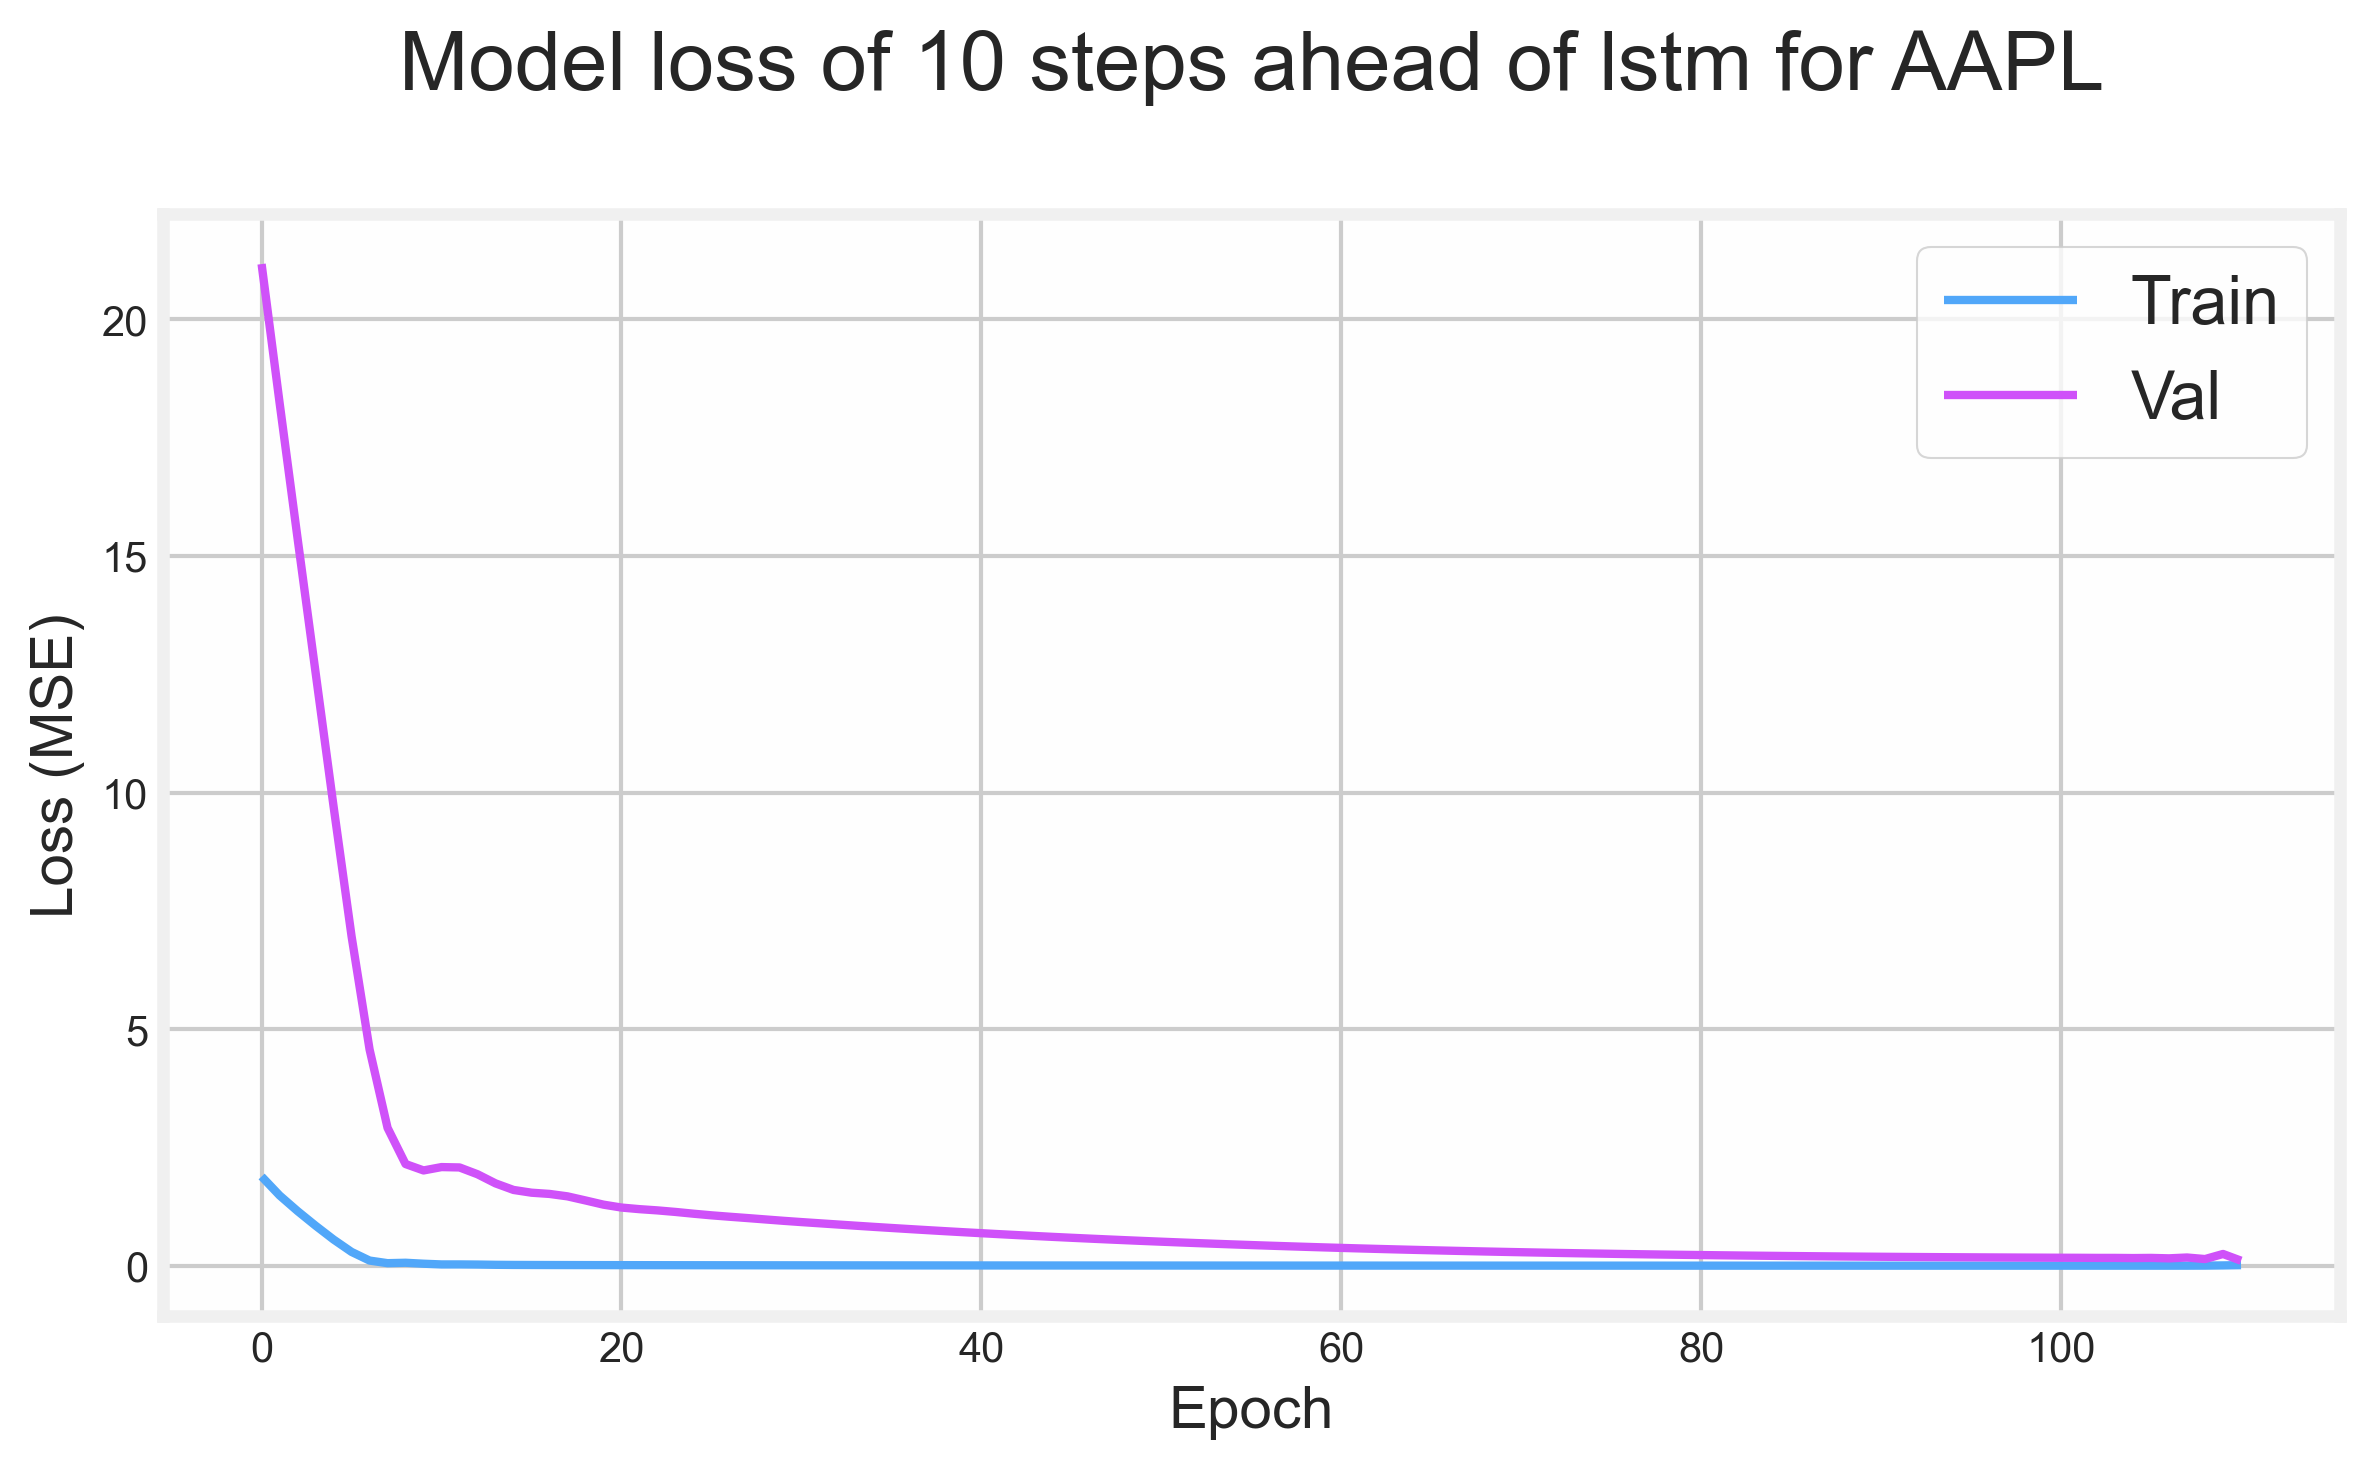

In [29]:
for key in params.keys():
    history = np.load(PATH + hist_folder + history_name +
                      '.npy', allow_pickle='TRUE').item()

    plotting.plot_train_val_loss(
        history, key, ticker, n_steps, n_steps_ahead)

## Save the fitted models

In [30]:
lags = str(n_steps)

if do_training:
    for key in params.keys():
        params[key]['model'].save('../../trained-RNNs/' + folder + model_name + key + lags +
                                  '.hdf5', overwrite=True)

## Prediction

In [31]:
y_test = y_test.reshape(-1, n_steps_ahead)

for key in params.keys():
    model = params[key]['model']
    model.summary()

    params[key]['pred_train'] = model.predict(x_train, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_train steps ahead: ' + str(i+1)] = mean_squared_error(y_train[:, i],
                                                                               params[key]['pred_train'][:, i])
    params[key]['pred_val'] = model.predict(x_val, verbose=True)    

    params[key]['pred_test'] = model.predict(x_test, verbose=True)
    for i in range(n_steps_ahead):
        params[key]['MSE_test steps ahead:' +
                    str(i+1)] = mean_squared_error(y_test[:, i], params[key]['pred_test'][:, i])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
32/32 [==============================] - 0s 1ms/step


In [32]:
# get the results
compare = params.keys() 

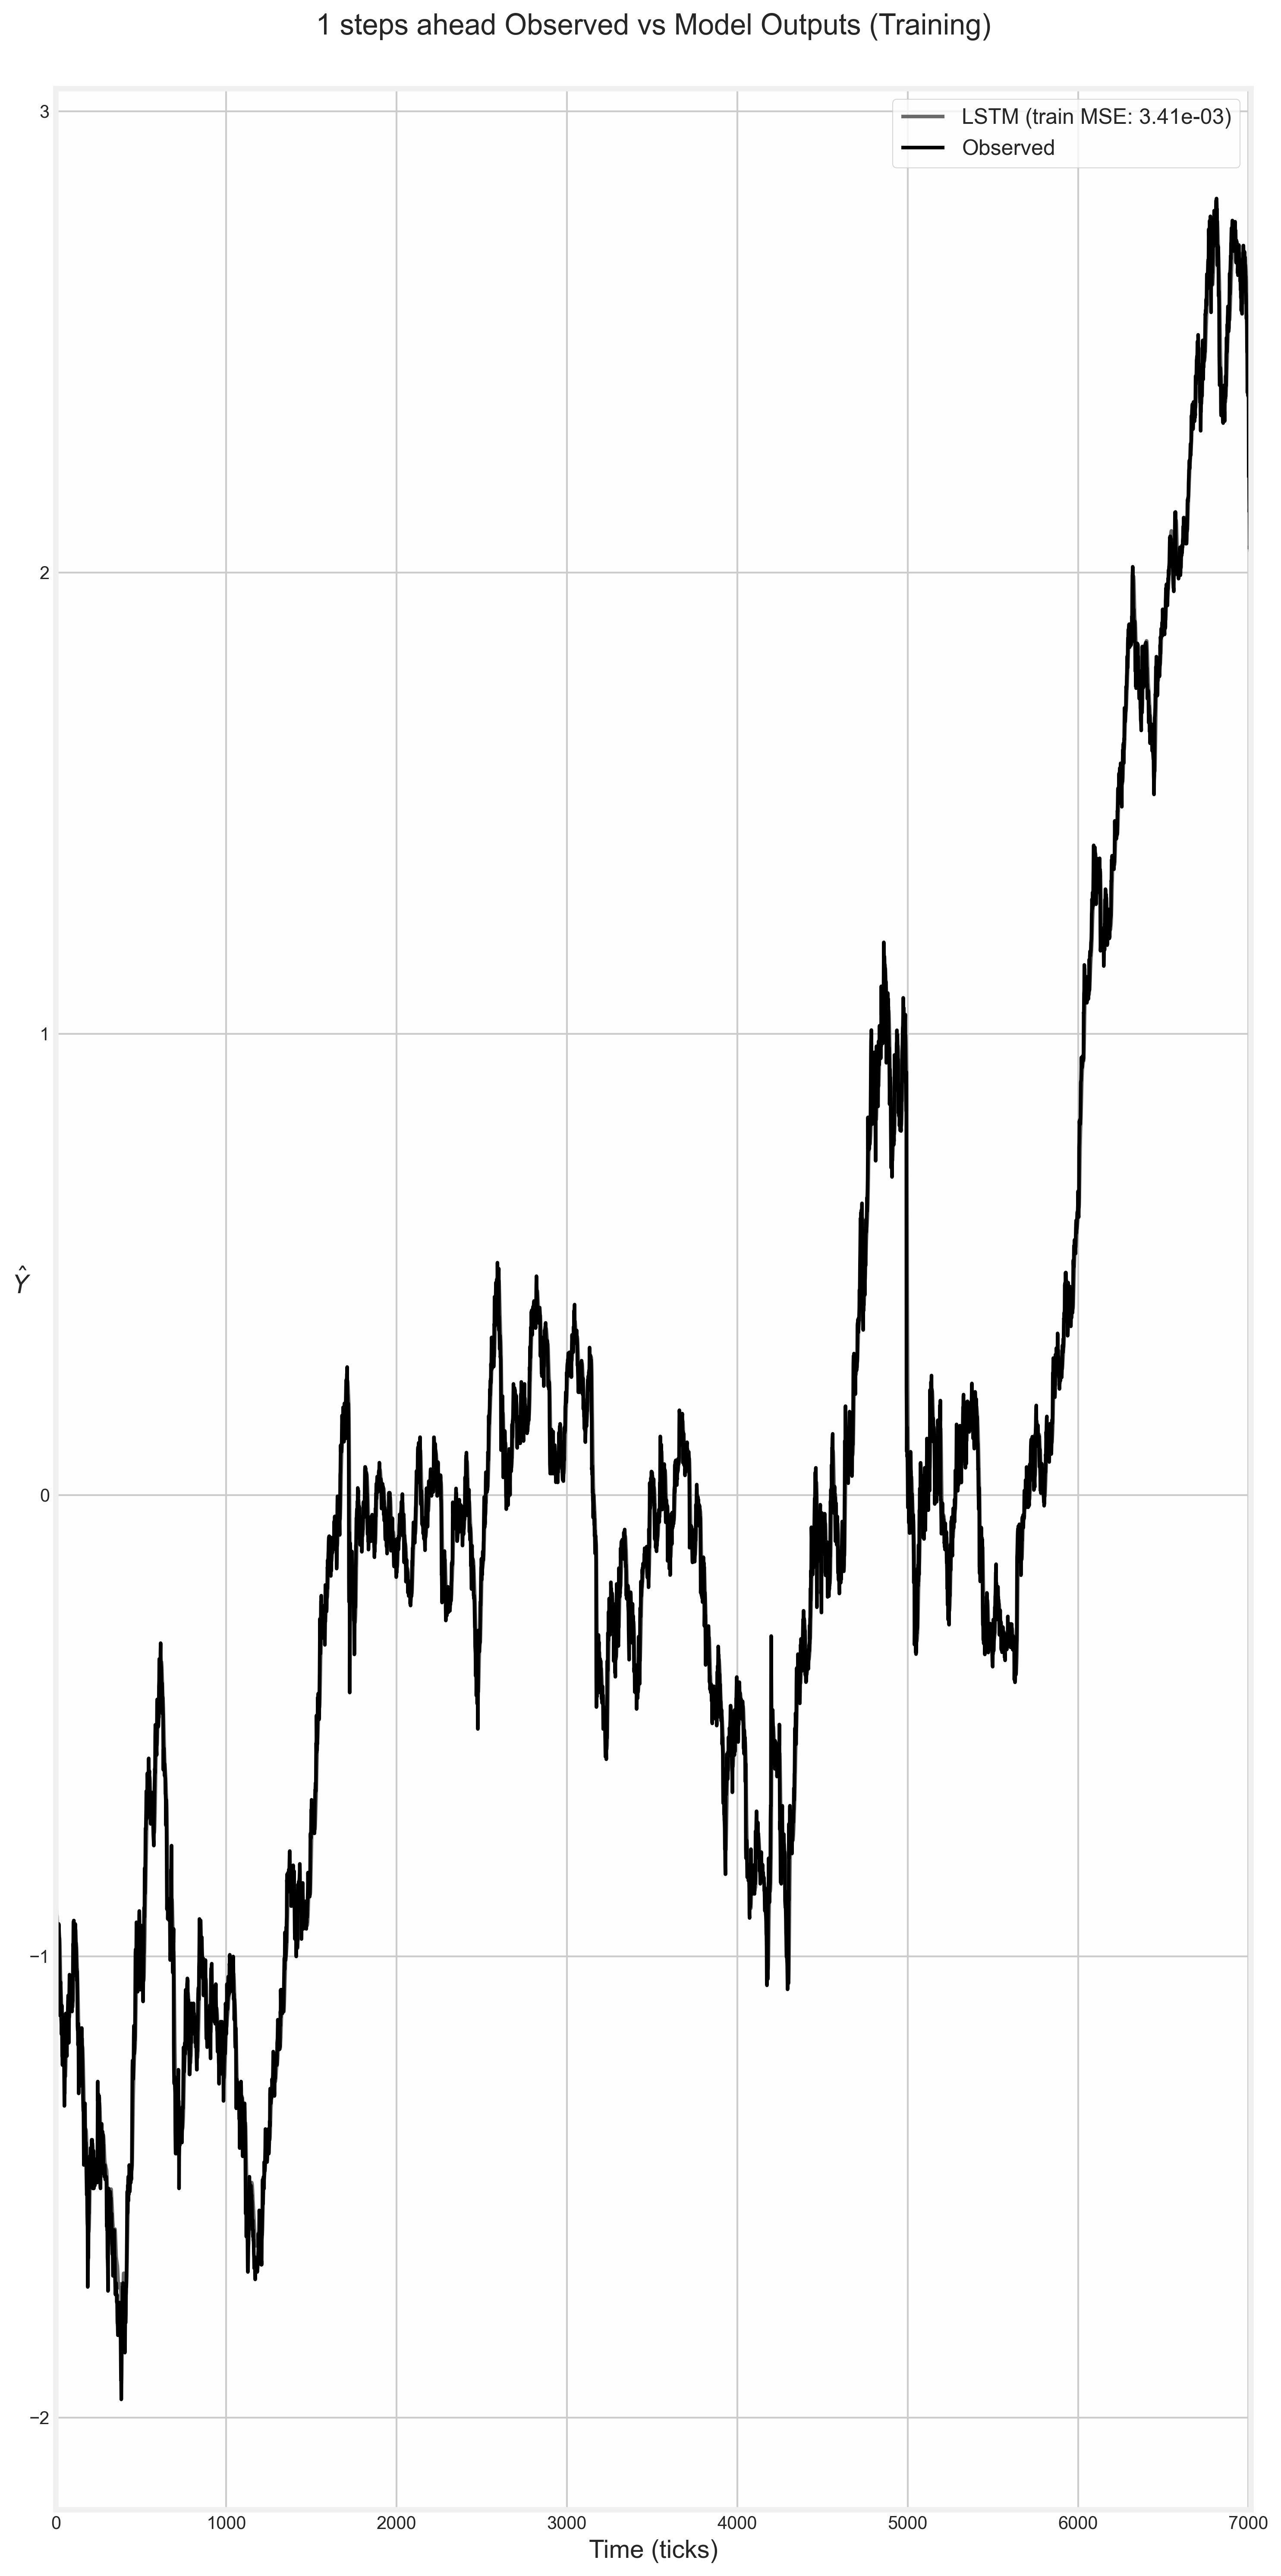

In [33]:
title_train = ' steps ahead Observed vs Model Outputs (Training)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

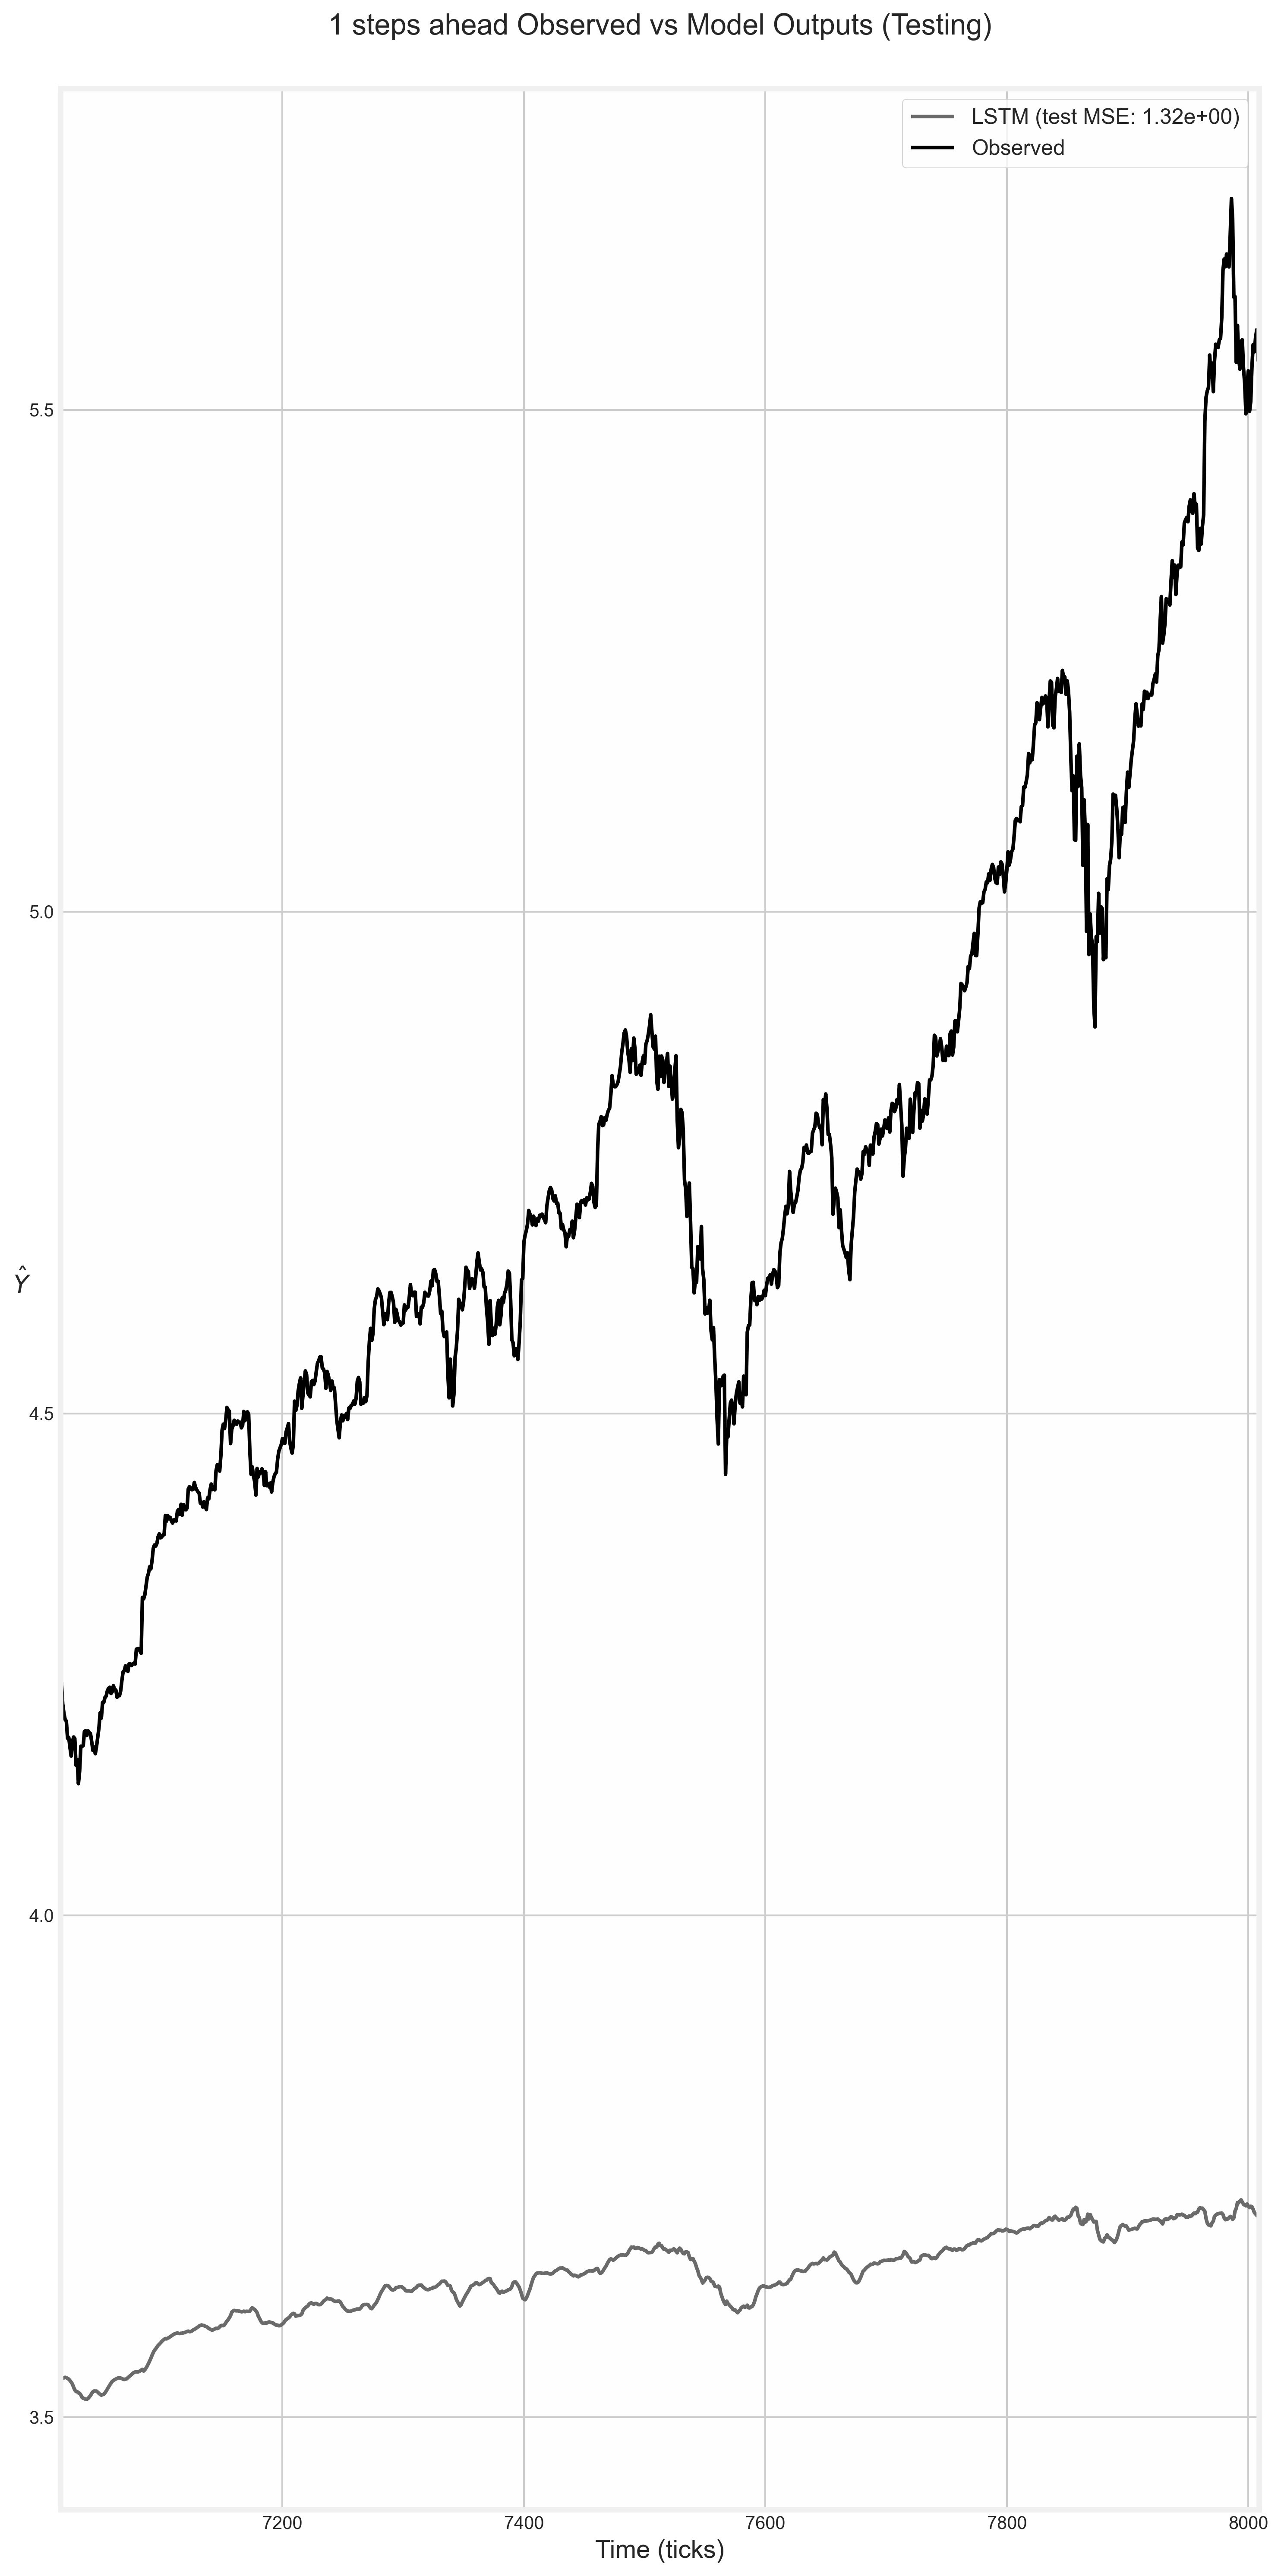

In [34]:
title_test = ' steps ahead Observed vs Model Outputs (Testing)'
plotting.prediction_vs_observed_plot(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

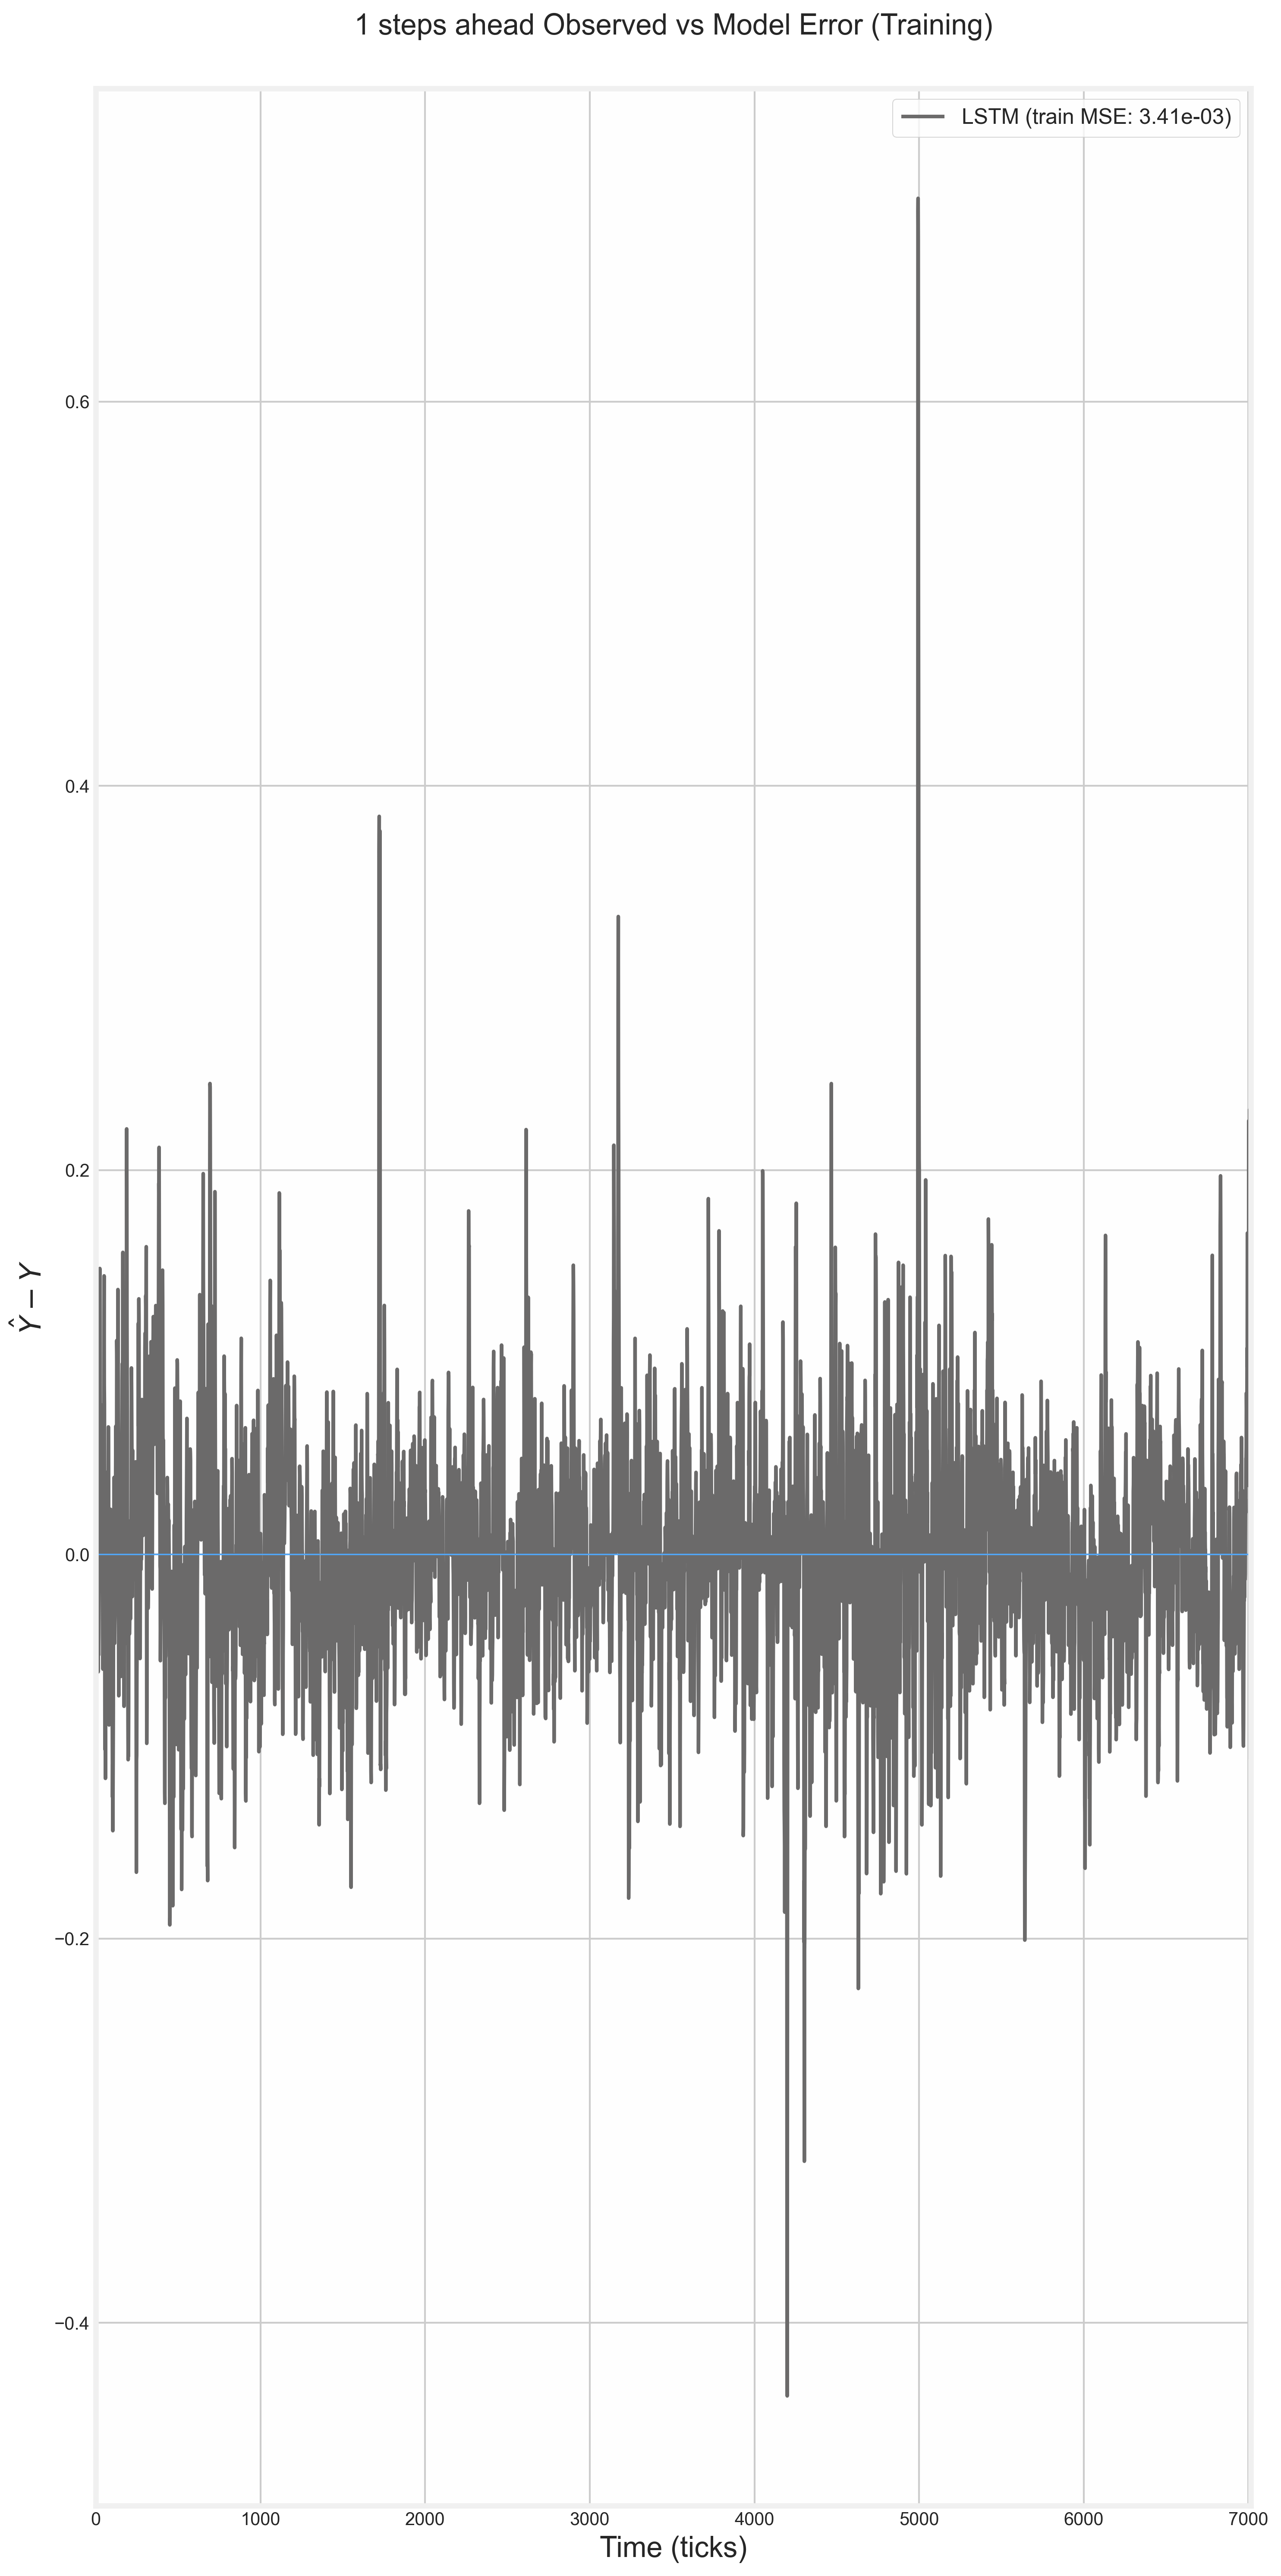

In [35]:
title_train = 'steps ahead Observed vs Model Error (Training)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_train, trainplot=True)

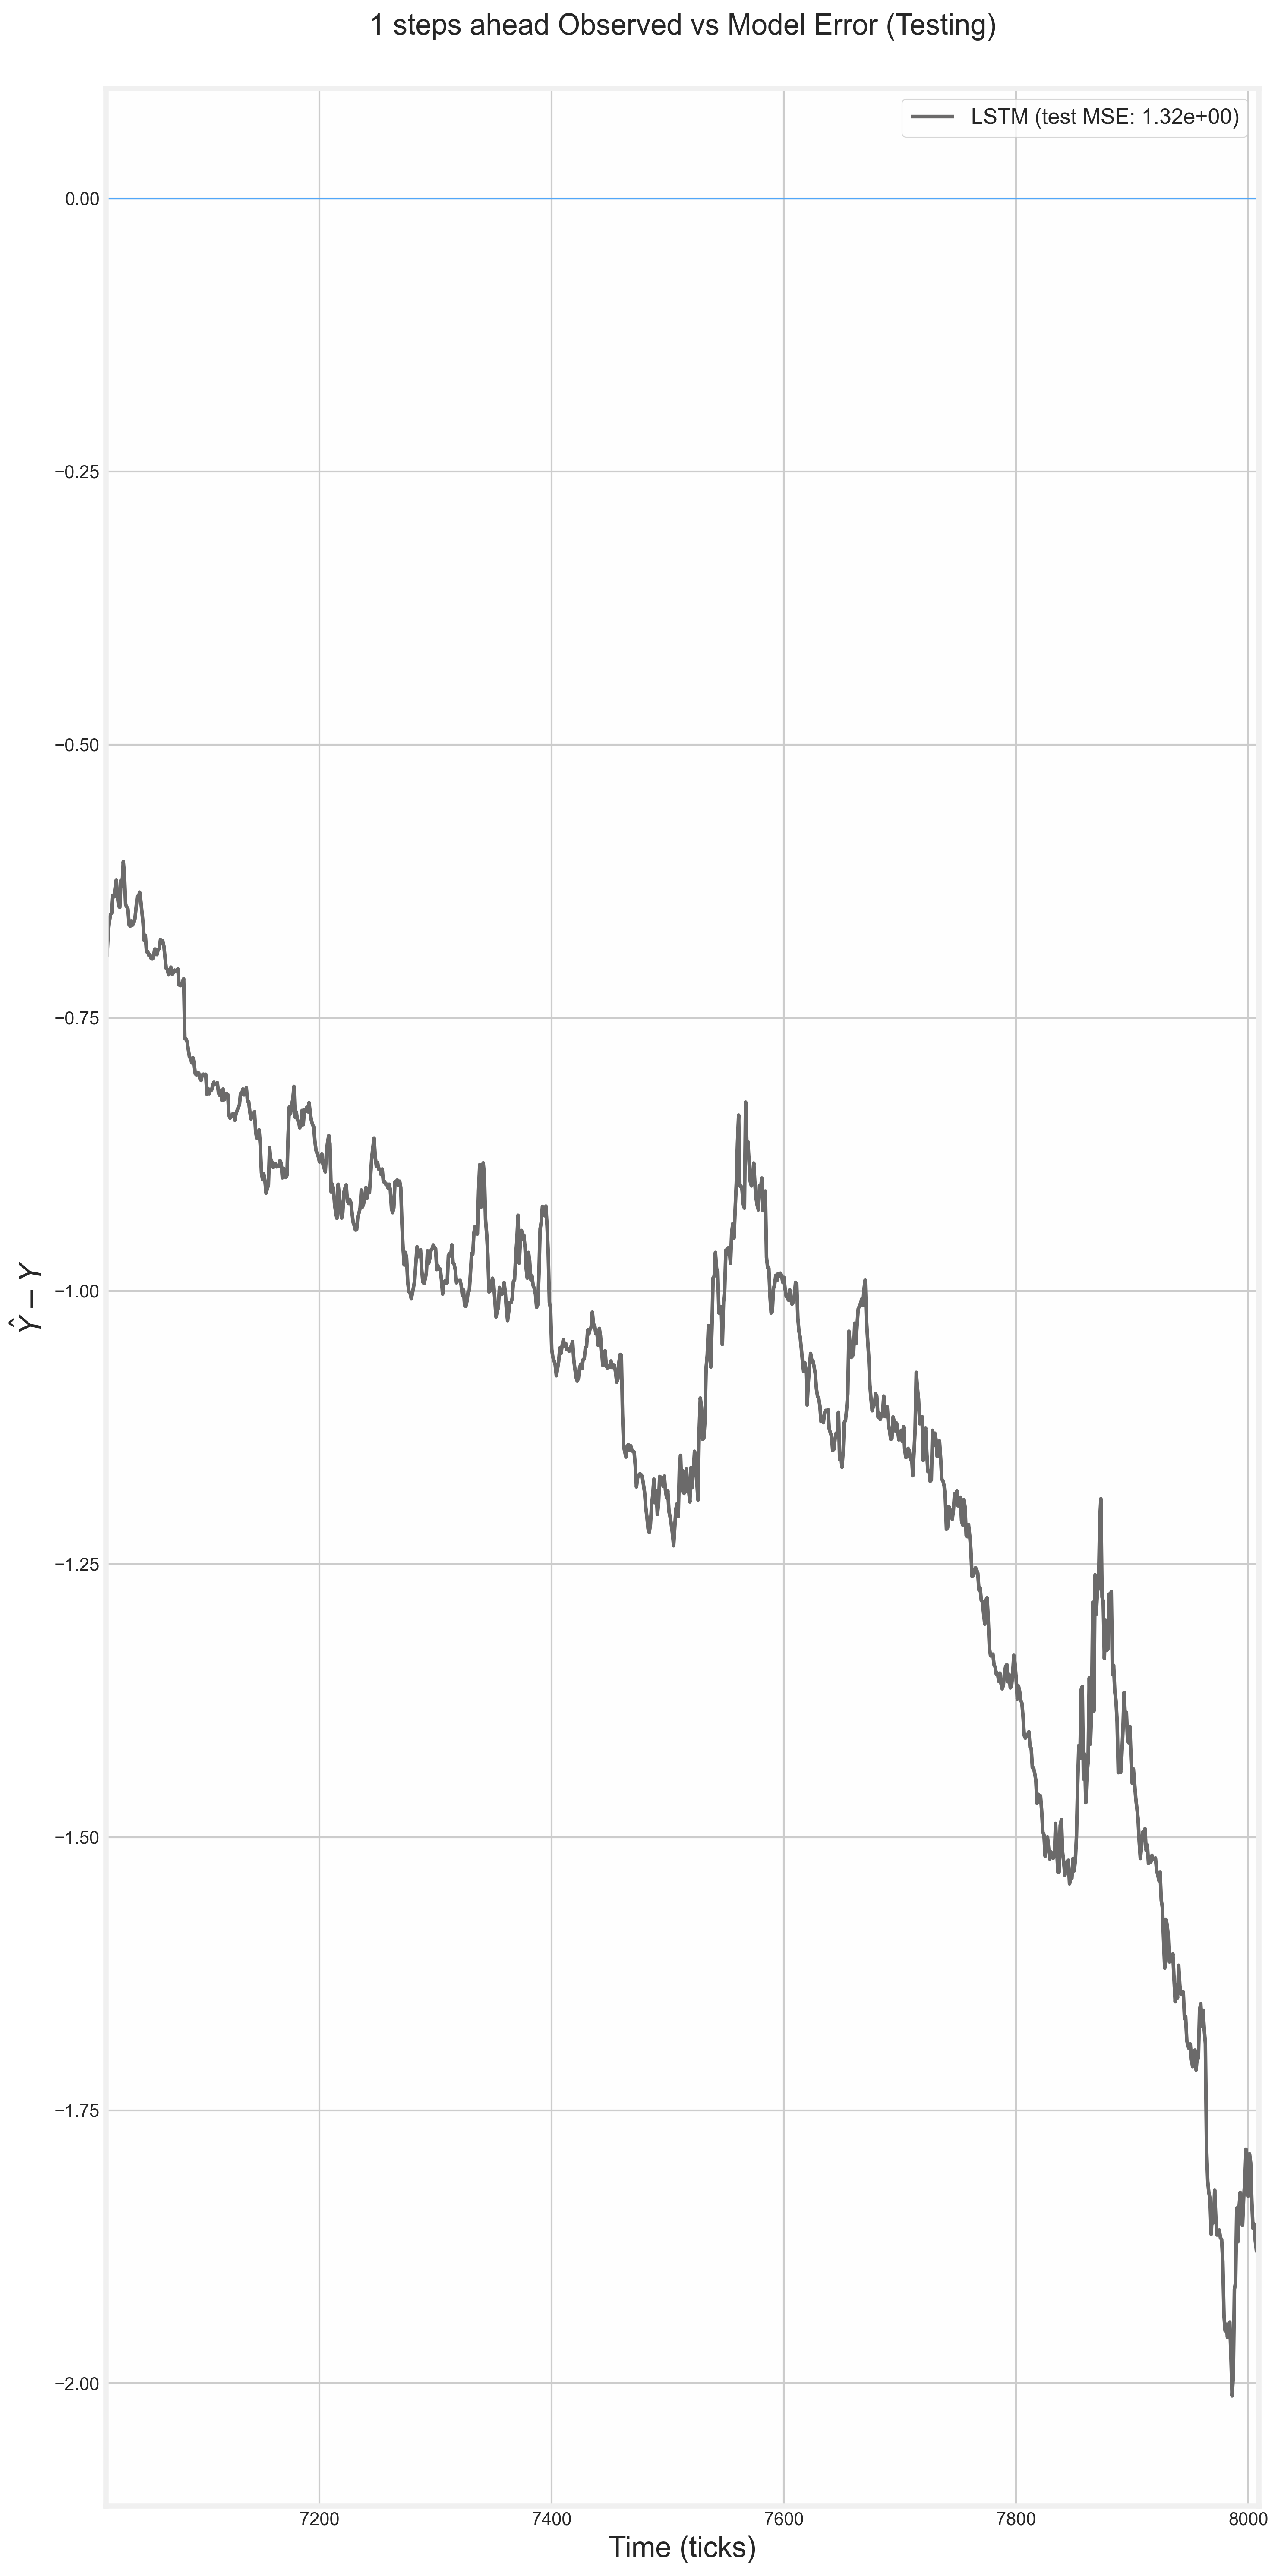

In [36]:
title_test = 'steps ahead Observed vs Model Error (Testing)'
plotting.error_plot_timeline(
    compare, params, n_steps_ahead, y_train, y_test, title=title_test, trainplot=False)

[1.3240239402598328]


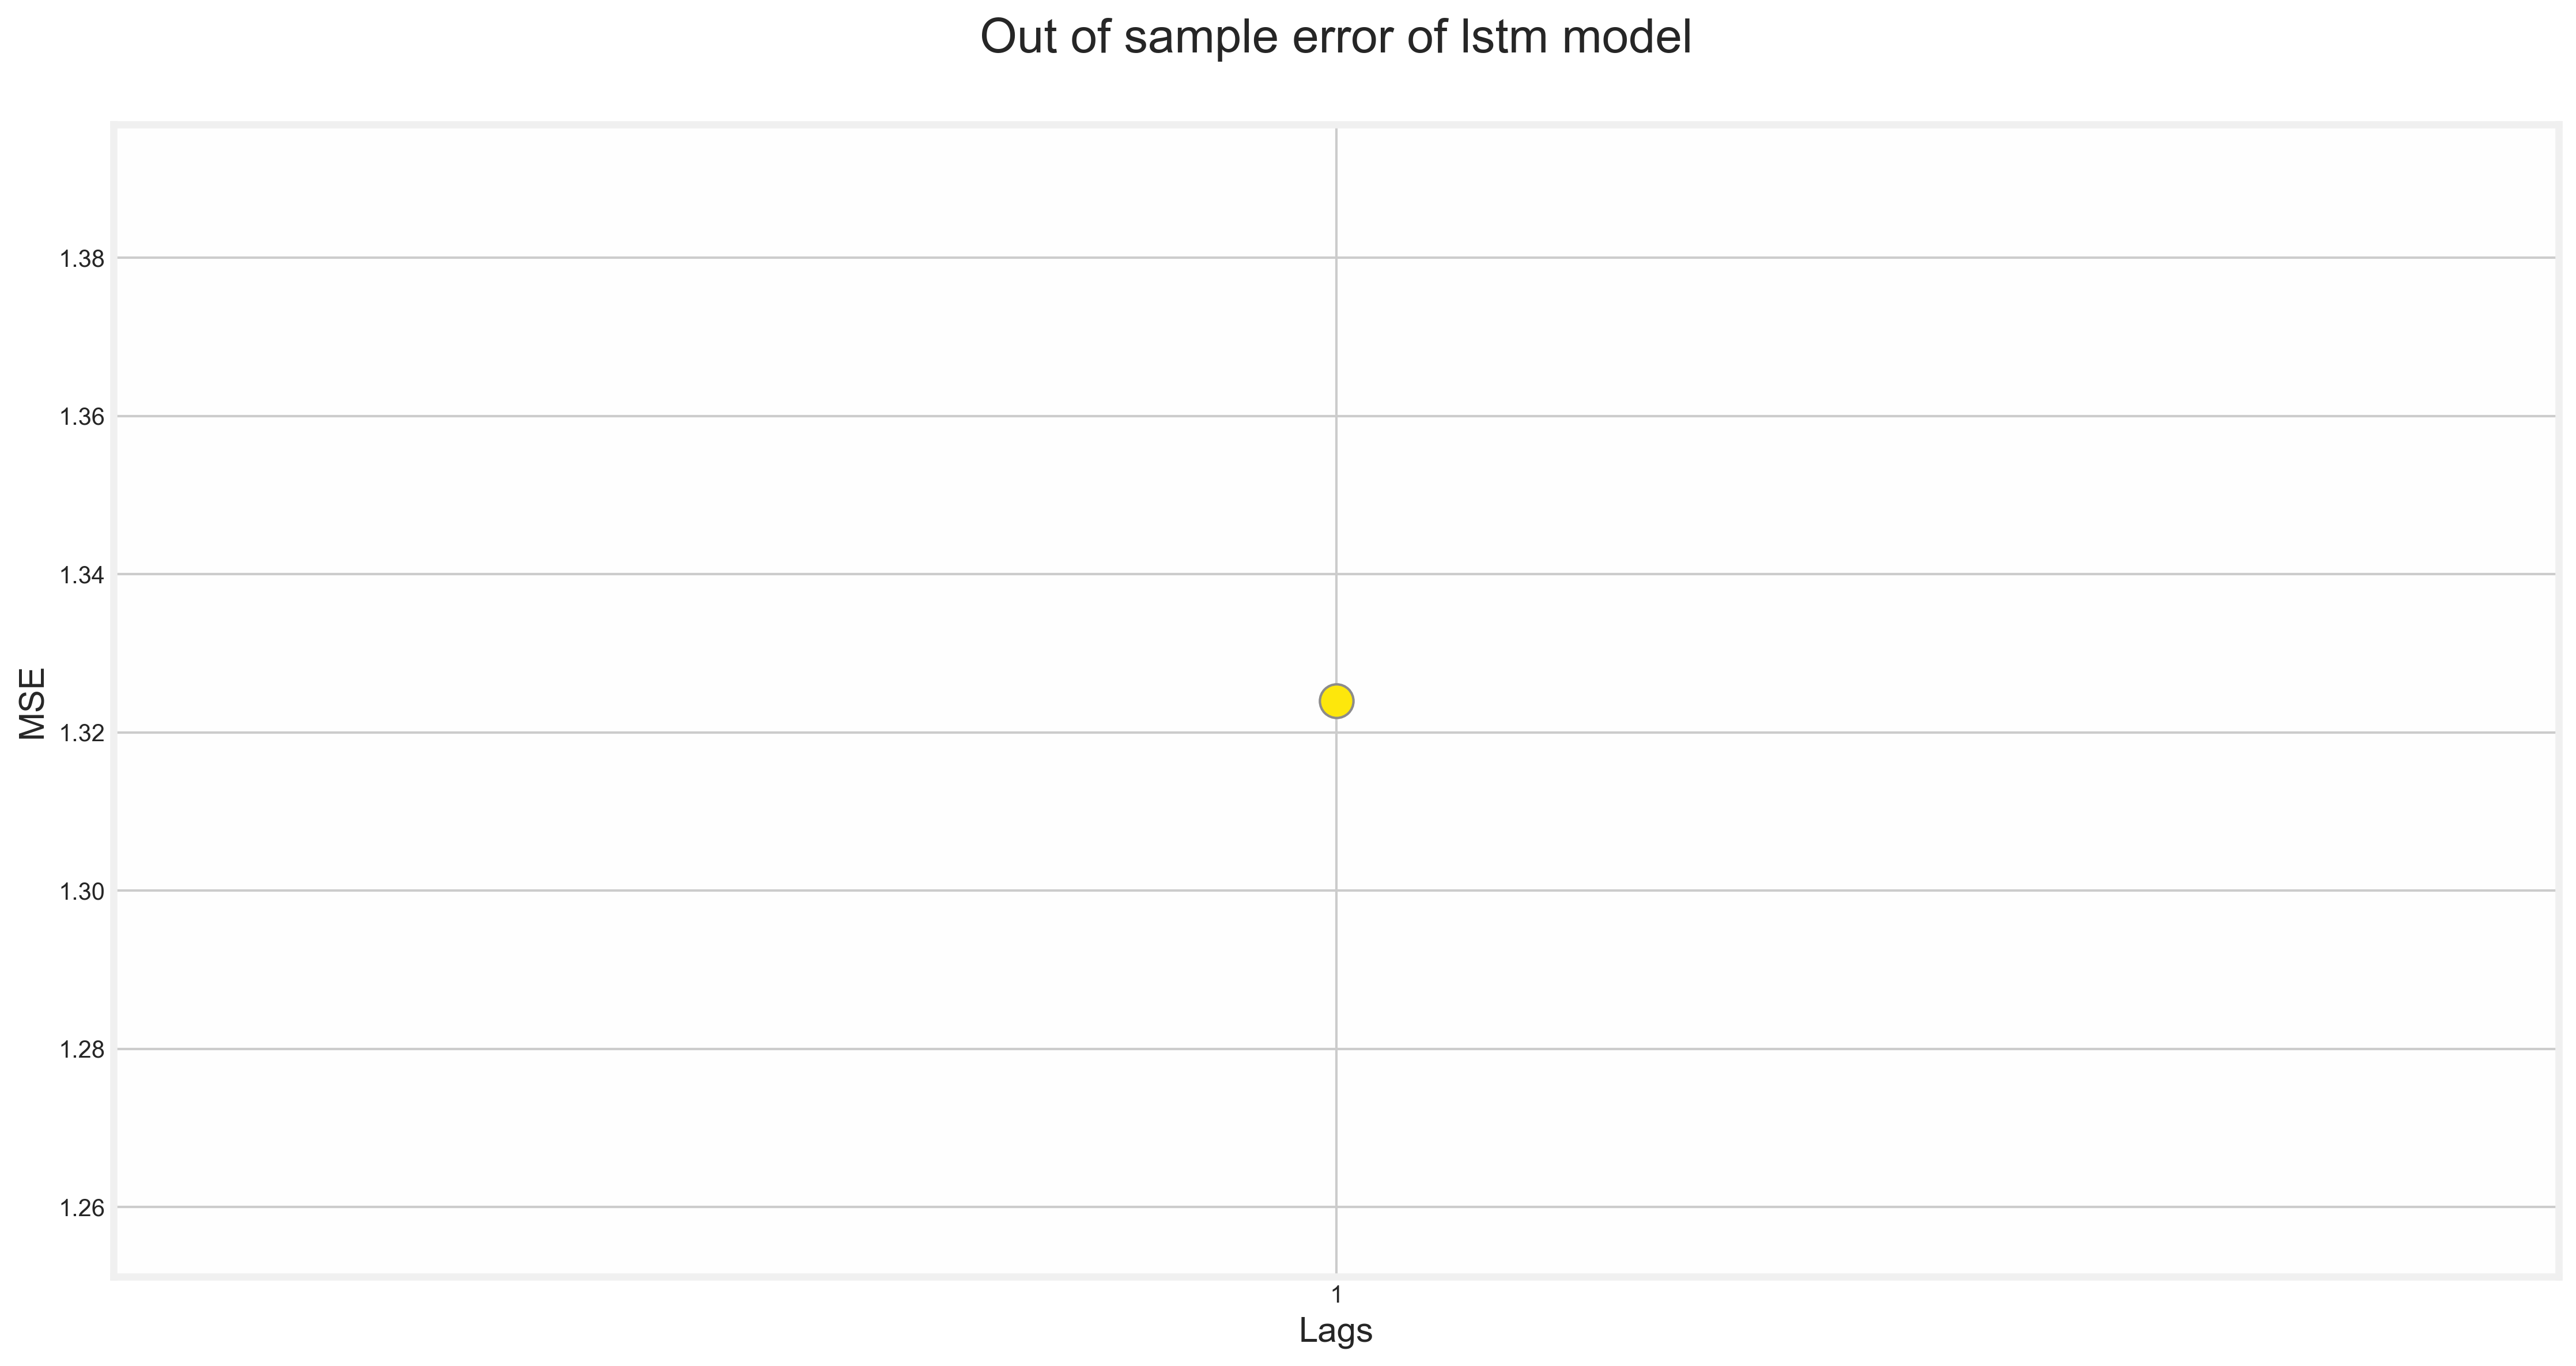

In [37]:
for key in compare:
    plt.figure(figsize=(15, 8))
    title = 'Out of sample error of ' + key + ' model'
    plotting.error_plot(y_test, params[key]['pred_test'], n_steps_ahead, title)

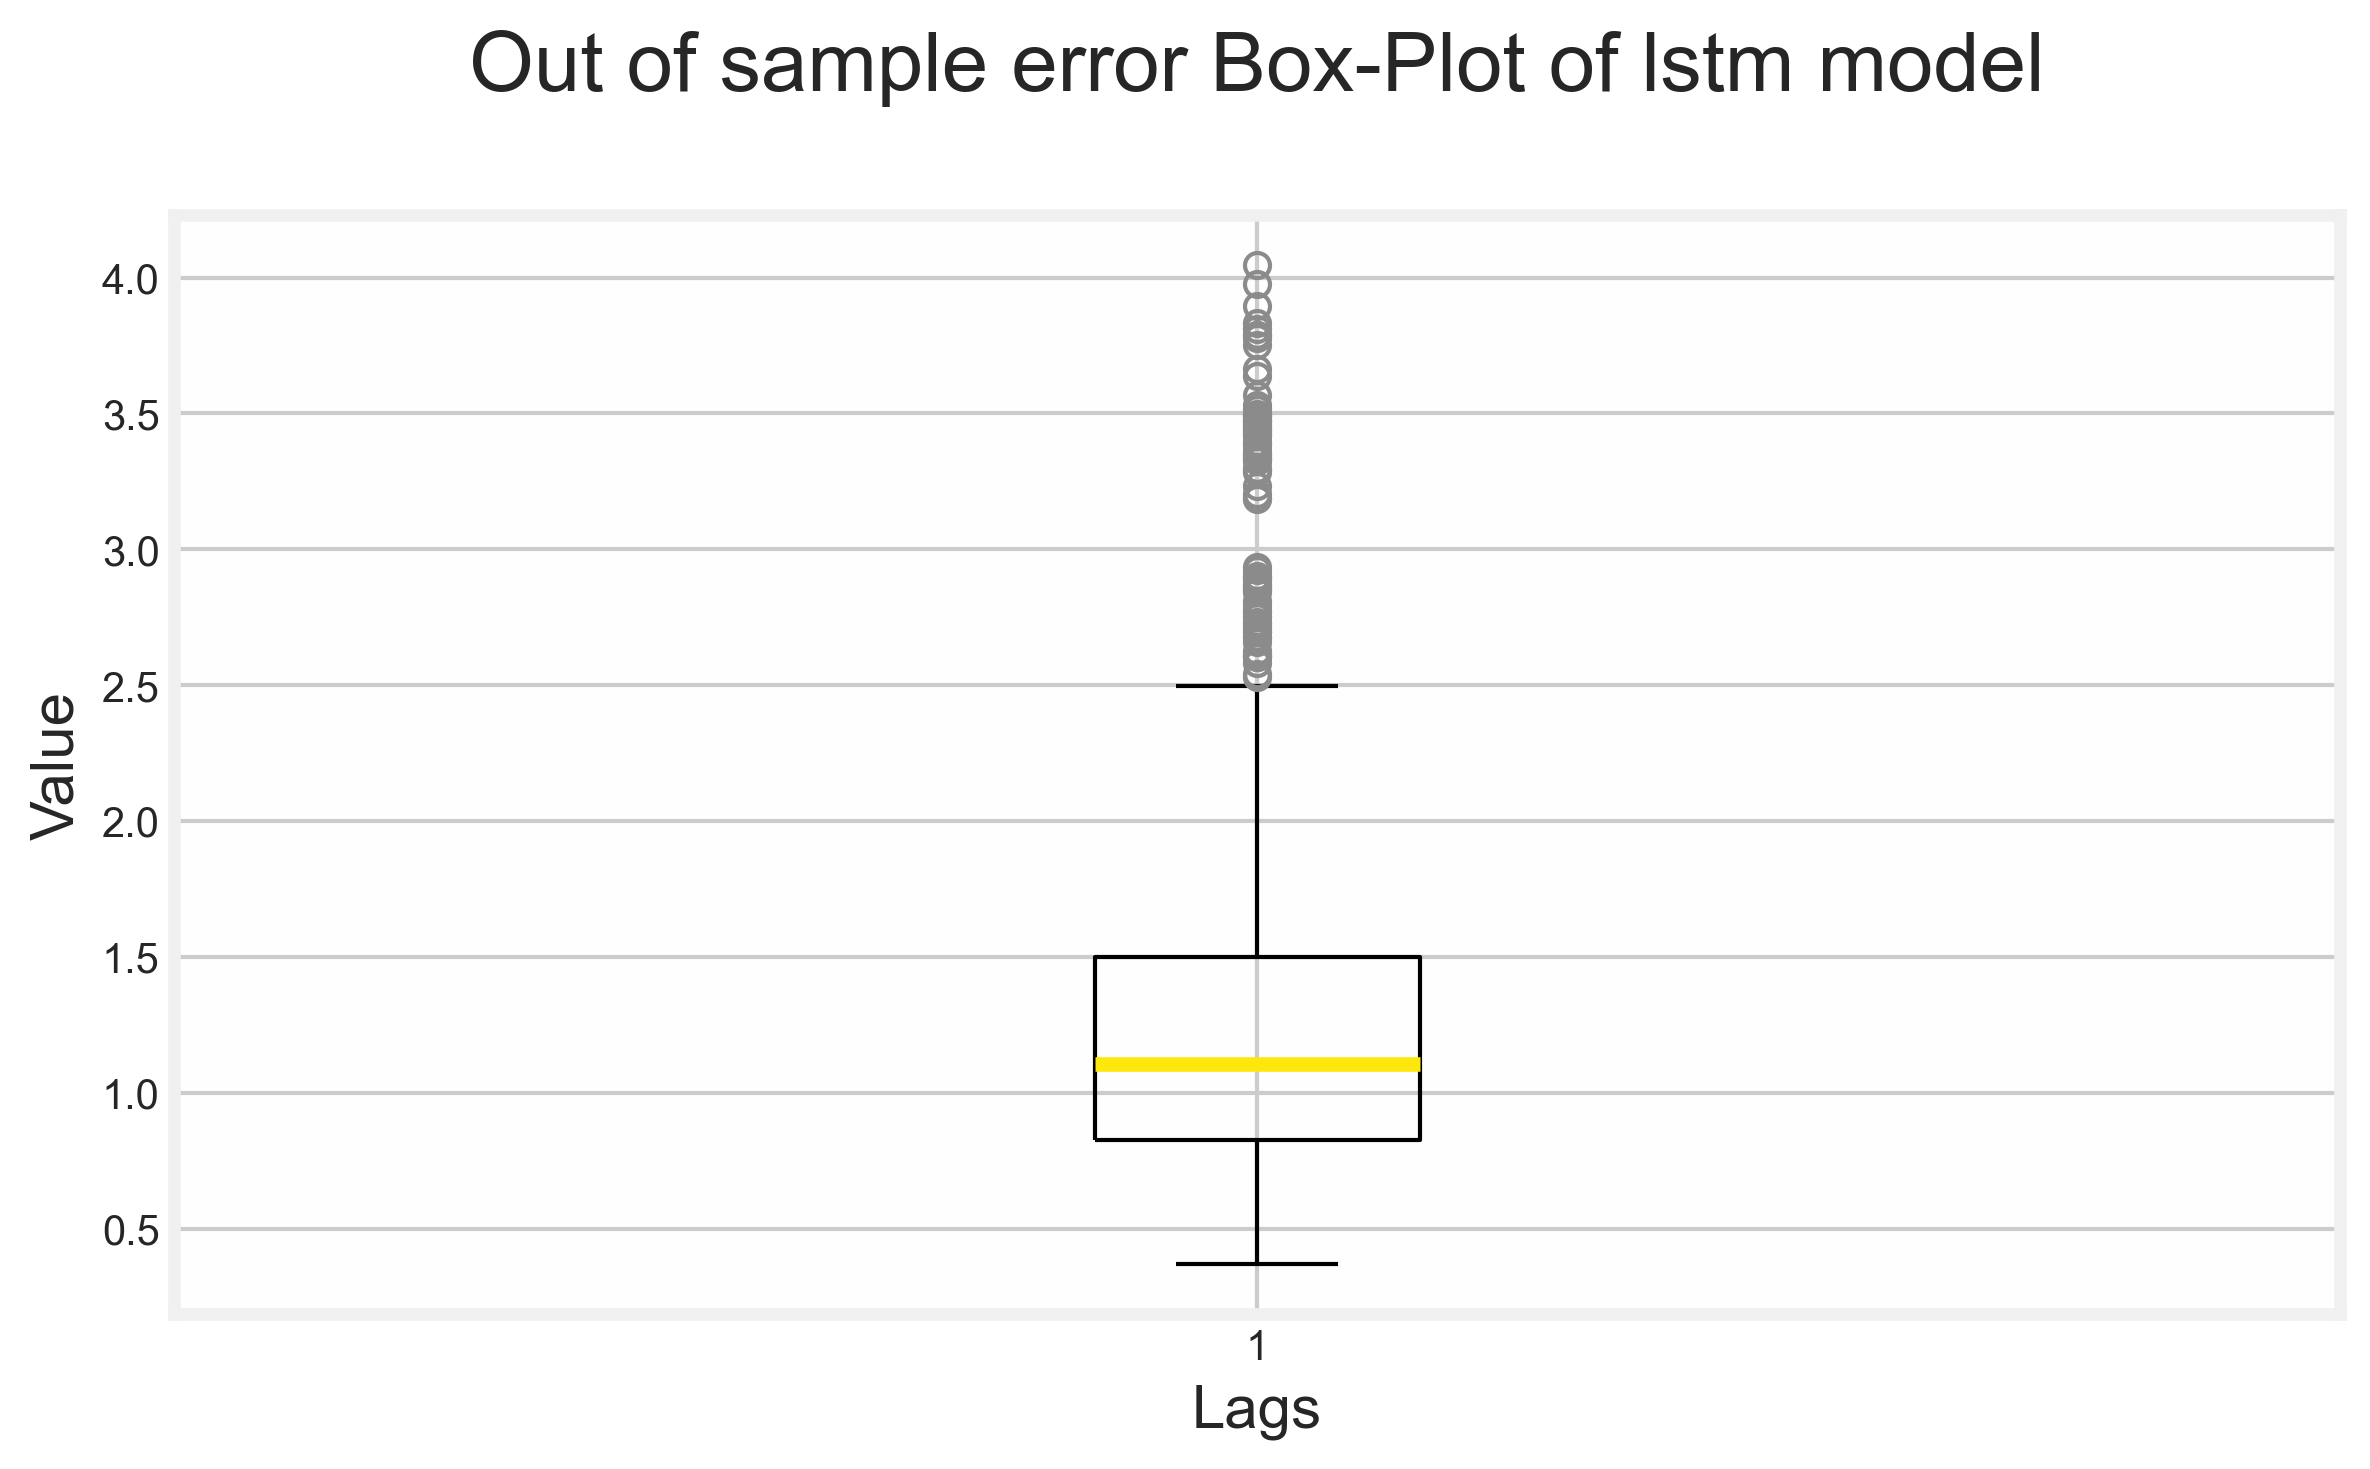

In [38]:
for key in compare:
    title = 'Out of sample error Box-Plot of ' + key + ' model'
    plotting.error_boxplot(
        y_test, params[key]['pred_test'], n_steps_ahead, title)

# Model Diagnostics

## Evaluate model

To gain more insights about the overall performance of the model, we use tensorflow's `evaluate()` function. 

In [39]:
# store the model performance
model_performance = {}

lags = str(n_steps)

# init the names

performance_name_train = key + '_' + ticker + '_' + lags + '_train_price'
performance_name_val = key + '_' + ticker + '_' + lags + '_val_price'
performance_name_test = key + '_' + ticker + '_' + lags + '_test_price'


# eval the model
for key in params.keys():
    model = params[key]['model']
    
    model_performance[performance_name_train] = model.evaluate(x_train, y_train)
    model_performance[performance_name_val] = model.evaluate(x_val, y_val)
    model_performance[performance_name_test] = model.evaluate(x_test, y_test)

    
metrics_evaluate = ma.get_eval_df(model_performance)
metrics_evaluate

32/32 [==============================] - 0s 1ms/step - loss: 1.3240 - mse: 1.3240 - mae: 1.1134


,MSE,MAE
lstm_AAPL_10_train_price,0.00341457,0.04189800
lstm_AAPL_10_val_price,0.17081062,0.34663397
lstm_AAPL_10_test_price,1.32402396,1.11339104


In [40]:
# save the date frame
evaluate_path = '../../model_evaluate/'
evaluate_folder = '{}/'.format(ticker)

evaluate_file_name = '_evaluate_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)


metrics_evaluate.to_csv(
    evaluate_path + evaluate_folder + key + evaluate_file_name)

## Grid search

In [41]:
model_scores = results_df.filter(regex=r'split\d*_test_score')
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores
tscv = TimeSeriesSplit(n_splits=5)

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(tscv.split(x_train, y_train))[0][0])
n_test = len(list(tscv.split(x_train, y_train))[0][1])

t_stat, p_val = ma.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\n"
      f"Corrected p-value: {p_val:.3f}")

Corrected t-value: -0.572
Corrected p-value: 0.299


In [42]:
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
      f"Uncorrected p-value: {p_val_uncorrected:.3f}")


Uncorrected t-value: -1.278
Uncorrected p-value: 0.135


In [43]:
# intitialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=ma.corrected_std(differences, n_train, n_test)
)

Saving figure:  post_dist_plot_price_AAPL_n_steps_10_n_steps_ahead_1


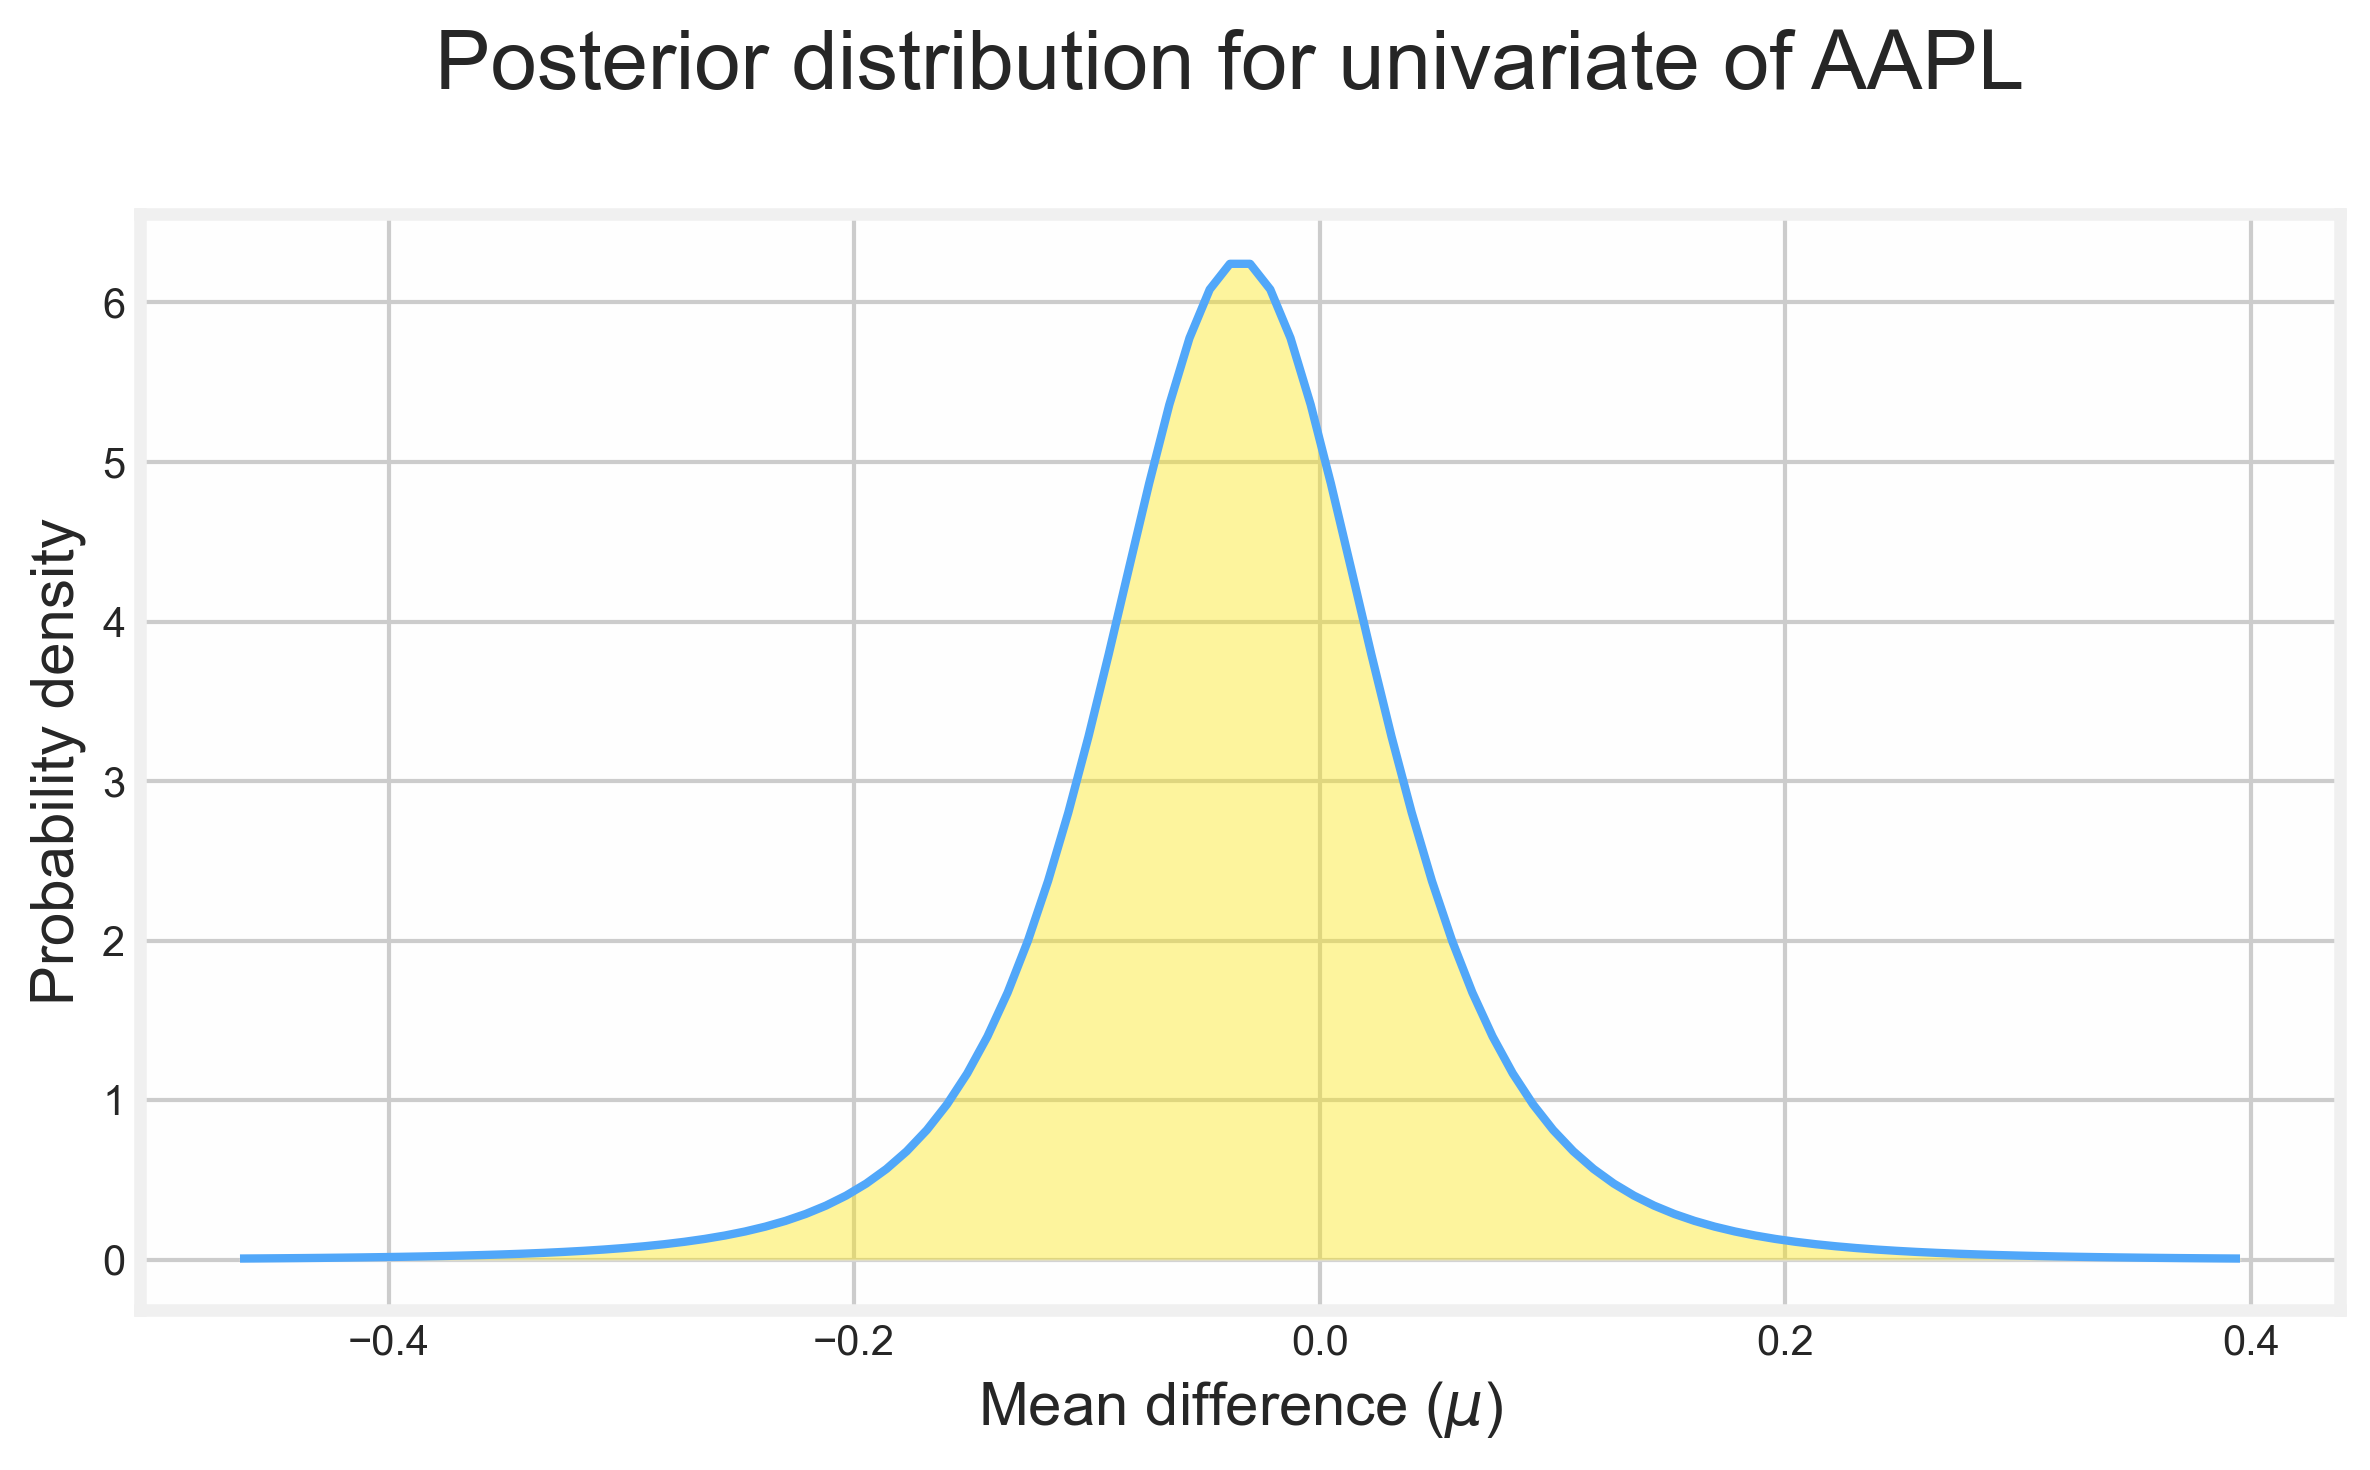

In [44]:
plotting.plot_post_distribution(t_post, ticker, n_steps, n_steps_ahead)

In [45]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of model {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of model {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of model 0 being more accurate than 1: 0.299
Probability of model 1 being more accurate than 0: 0.701


Saving figure:  Histogramm_plot_price_AAPL_n_steps_10_n_steps_ahead_1


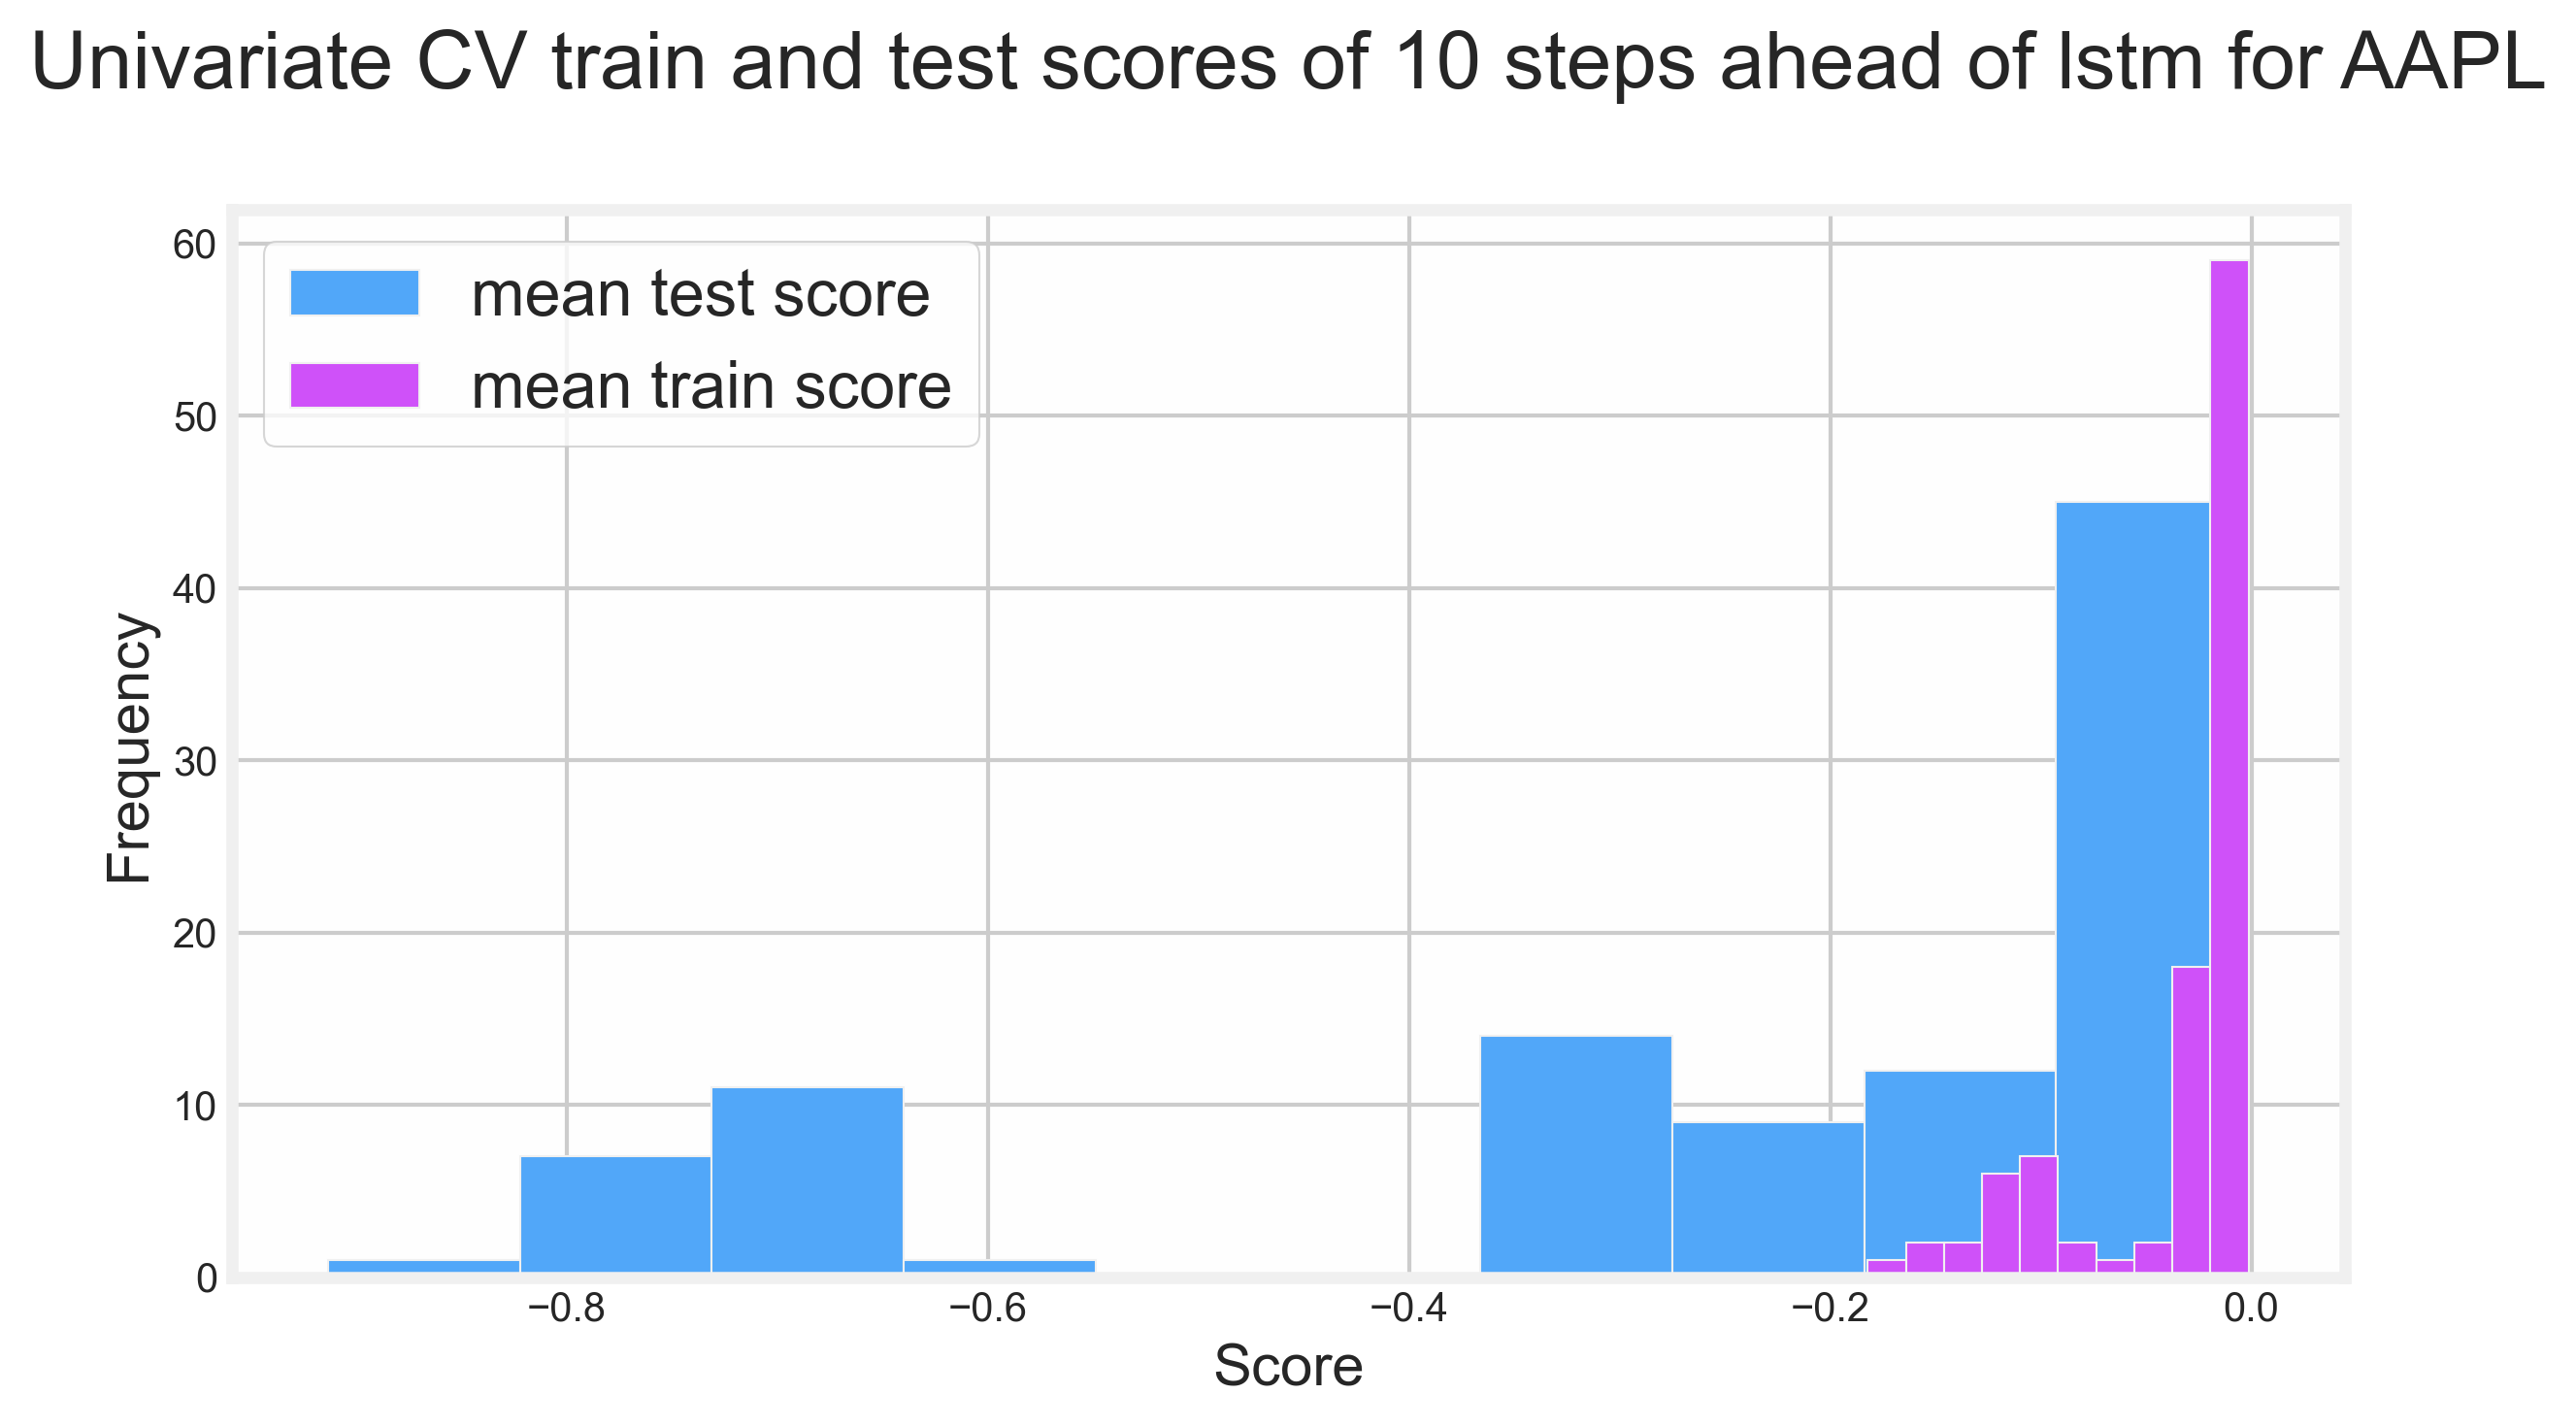

In [46]:
plotting.plot_CV_histogram(results_df, key, ticker, n_steps, n_steps_ahead)

## Rescaled model metrics 

In [47]:
predicted = params[key]['pred_test']


In [51]:
# get rescaled MAPE of 
metrics_df = ma.get_rescaled_mape_r2(y_test, predicted, mu, sigma, n_steps_ahead)
metrics_df

,MAPE,$R^2$
lag,,
1,67.9884,-3.0509


In [52]:
analysis_path = '../../model_analysis/'
analysis_folder = '{}/'.format(ticker)

analysis_file_name = '_metrics_df-price-{}-{}-n_steps.csv'.format(
    ticker, n_steps)

metrics_df.to_csv(analysis_path + analysis_folder + key + analysis_file_name)

# Plot observed vs. predicted

Saving figure:  lstm_stock_price_plot_price_AAPL_n_steps_10_n_steps_ahead_1


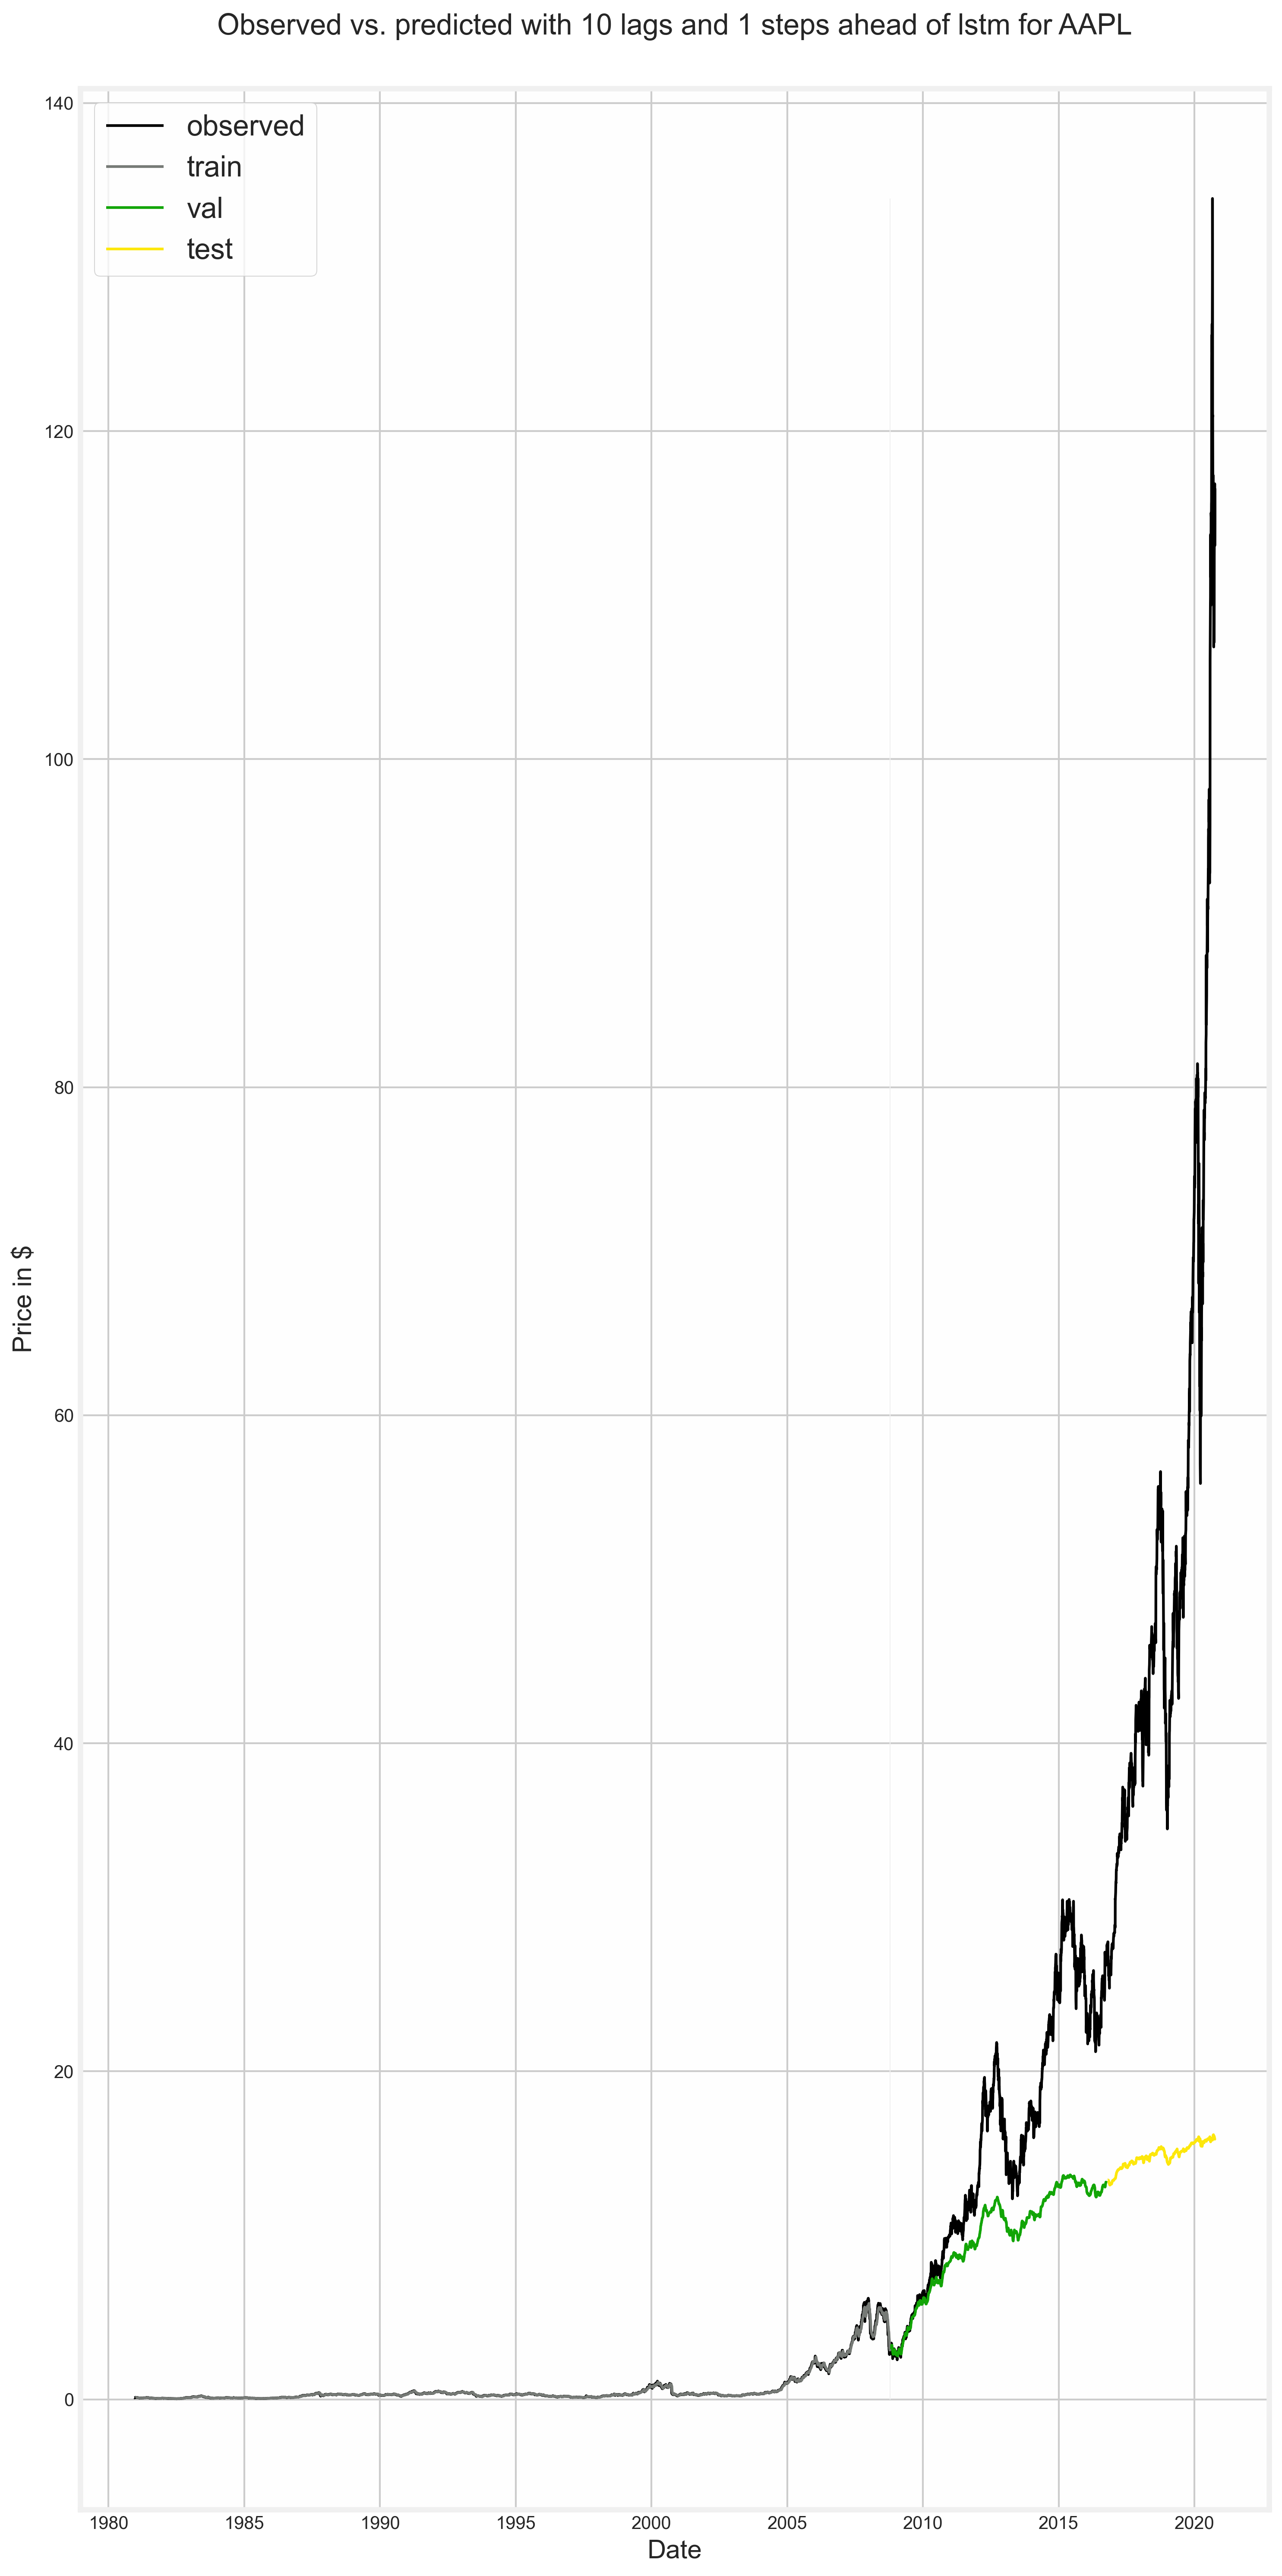

In [54]:
# rescale observed and predicted to compare
plotting.scaled_observed_vs_predicted_plot(data, key, ticker, data_train, data_val,
                                           data_test, mu, sigma, params, n_steps, n_steps_ahead)